# Project: Car Price prediction (part 2 - Clearing Data) 

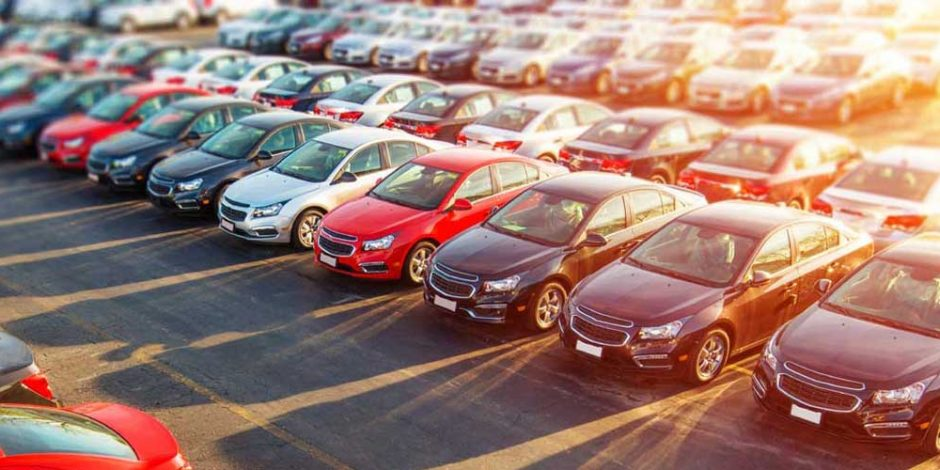

Цель данного ноутбука только разбор данных полученных после парсинга с сайта auto.ru 

Это этап для корректировки данных и их первичного изучения.

<a id='chapters'>План действий:</a>
1. [Загружаем тренировочные данные и смотрим их](#p_1)
2. [Выводы](#p_2)

Итак, всё есть - приступим.

<p style="color:green">#############################################################################################</p>  

## Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np

import time
import datetime
from tqdm.auto import tqdm, trange
from pprint import pprint

import requests
import json
import re
from bs4 import BeautifulSoup

import glob
import os
    
from collections import Counter

## Собственные функции

In [2]:
# функция по исправлению ошибок парсинга
# работает с сохраненными файлами парсинга
# и собирает номер объявления и корректные данные по признакам

def get_lost_value():
    # создаем dataframe для новых данных
    df = pd.DataFrame(columns=['card_id', 'productionDate','vehicleConfiguration'])
    
    # используем маску по файлам (чтобы случайно не обрабатывать ненужные файлы)
    mask = './data/parsing/'
    files = glob.glob(os.path.join(mask, "*.txt"))

    # создаем статус бар для визуализации прогресса работы функции
    pbar_links=tqdm(range(0,len(files)))

    # пошли циклом по списку файлов
    for file in pbar_links:
        pbar_links.set_description("Парсим файл " + str(file+1))
        
        # получаем имя файла
        file = files[file]
        
        # считываем файл и конвертируем его в soup
        with open(file,encoding='utf-8') as file_open:
            soup = BeautifulSoup(file_open, "html.parser")
        
        # ищем все разделы script
        scr = soup.find_all("script")
        
        # а теперь ищем потерянные признаки
        
        # каждый признак с своим обработчиком ошибки
        try:
            card_id = str(soup.find('div', class_='CardHead__infoItem CardHead__id').text[2:])
        except:
            card_id = np.NaN
        
        # каждый признак с своим обработчиком ошибки
        try:
            productionDate = re.search(r'"productionDate":.*?,',str(scr))[0][17:-1]
        except:
            productionDate = np.NaN

        # каждый признак с своим обработчиком ошибки 
        try:
            vehicleConfiguration = str(re.search(r'vehicleConfiguration":.*?,',str(scr))[0][23:-2])
        except:
            vehicleConfiguration = np.NaN
        
        # добавляем новые данные в dataframe
        df.loc[len(df)] = [card_id, productionDate,vehicleConfiguration]
        
    return df

In [3]:
# функция первияного просмотра данных
def first_look(df,field):
    display(df[field].value_counts(dropna=False))
    print('В датасете -',df[field].nunique(),f' разных {field}')

    if len(df[df[field].isna()==True])>0:
        print('Есть пропуски - посмотрим на них')
        display(df[df[field].isna()==True].T)
    else:
        print('Пропусков нет')

In [178]:
# функция построения графика признака абсолютные и %
def print_field(field):
    print('Посмотрим на распределение признака ' + str(field))
    plt.figure(figsize=(8, 3))
    sns.set_style("darkgrid")
    plt.subplot(1, 2, 1)
    sns.barplot(x = df[field].value_counts(normalize=False).index,
                  y = df[field].value_counts(normalize=False)
                  , palette = "pastel")
    plt.title("Абсолютные значения " + str(field))
    plt.subplot(1, 2, 2)
    sns.barplot(x = df[field].value_counts(normalize=True).index,
                  y = df[field].value_counts(normalize=True)
                  , palette = "pastel")
    plt.title("Доля " + str(field))
    sns.set_style("darkgrid")

<p style="color:green">#############################################################################################</p><br>
<font size="5">  
<a id='p_1' style="color:blue">1. Загружаем тренировочные данные и смотрим их</a></font> 

[назад к оглавлению](#chapters) | [предыдущая часть](#chapters) | [следующая часть](#p_2)

<code style="background:greenYellow;color:black">Важно!  
Поскольку это первичный просмотр данных, то смотрю их на первичнособранном файле.
Моделирование будет опираться на другие исходные данные, которые будут просто в большем объеме.  
Но считаю это не навредит процессу.</code>

In [4]:
# загрузим исходные данные
df = pd.read_csv('auto_ru_data_audi_25_11.csv')

In [5]:
df.info()
df.sample(5).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7806 entries, 0 to 7805
Data columns (total 52 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              7799 non-null   object 
 1   brand                 7806 non-null   object 
 2   car_url               7806 non-null   object 
 3   color                 7799 non-null   object 
 4   complectation_dict    7806 non-null   object 
 5   description           7658 non-null   object 
 6   engineDisplacement    7806 non-null   object 
 7   enginePower           7806 non-null   object 
 8   equipment_dict        7806 non-null   object 
 9   fuelType              7806 non-null   object 
 10  image                 7450 non-null   object 
 11  mileage               7799 non-null   float64
 12  modelDate             7799 non-null   float64
 13  model_info            7806 non-null   object 
 14  model_name            0 non-null      float64
 15  name                 

,5995,5581,4495,7250,6971
bodyType,седан,универсал 5 дв.,купе,внедорожник 5 дв.,седан
brand,AUDI,AUDI,AUDI,AUDI,AUDI
car_url,https://auto.ru/cars/used/sale/audi/a6/1105968...,https://auto.ru/cars/used/sale/audi/a6/1106036...,https://auto.ru/cars/used/sale/audi/tt/1106091...,https://auto.ru/cars/used/sale/audi/q7/1105924...,https://auto.ru/cars/used/sale/audi/a6/1106016...
color,чёрный,бежевый,жёлтый,чёрный,чёрный
complectation_dict,"{""id"":""0""}","{""id"":""0""}","{""id"":""20733716"",""name"":""Sport"",""available_opt...","{""id"":""20943629"",""name"":""Business"",""available_...","{""id"":""0""}"
description,10 000 подарков за покупку автомобиля с пробег...,10 000 подарков за покупку автомобиля с пробег...,"Продаю свою Audi TT, в идеальном состоянии. Пр...",💸Выгода до 100 000 рублей при покупке в кредит...,ЛОТ: 01298416Локация №14Реутов VOLKSWAGENСкидк...
engineDisplacement,1.8 LTR,2.0 LTR,2.0 LTR,3.0 LTR,2.0 LTR
enginePower,190 N12,190 N12,230 N12,249 N12,249 N12
equipment_dict,"{""cruise-control"":true,""asr"":true,""leather-gea...","{""asr"":true,""airbag-driver"":true,""electro-wind...","{""esp"":true,""sport-seats"":true,""usb"":true,""mul...","{""cruise-control"":true,""esp"":true,""usb"":true,""...","{""cruise-control"":true,""asr"":true,""tinted-glas..."
fuelType,бензин,дизель,бензин,дизель,бензин


Получается у нашем наборе данных 16 числовых признаков и 36 номинальных.  
<a id='featches'>Посмотрим на признаки подробнее:</a>
1. [bodyType](#f_01)
1. [brand](#f_02)
1. [car_url](#f_03)
1. [color](#f_04)
1. [complectation_dict](#f_05)
1. [description](#f_06)
1. [engineDisplacement](#f_07)
1. [enginePower](#f_08)
1. [equipment_dict](#f_09)
1. [fuelType](#f_10)
1. [image](#f_11)
1. [mileage](#f_12)
1. [modelDate](#f_13)
1. [model_info](#f_14)
1. [model_name](#f_15)
1. [name](#f_16)
1. [numberOfDoors](#f_17)
1. [parsing_unixtime](#f_18)
1. [priceCurrency](#f_19)
1. [productionDate](#f_20)
1. [offers_dict](#f_21)
1. [sell_id](#f_22)
1. [super_gen](#f_23)
1. [vehicleConfiguration](#f_24)
1. [vehicleTransmission](#f_25)
1. [vendor](#f_26)
1. [Владельцы](#f_27)
1. [Владение](#f_28)
1. [ПТС](#f_29)
1. [Привод](#f_30)
1. [Руль](#f_31)
1. [Состояние](#f_32)
1. [Таможня](#f_33)
1. [car_price](#f_34)  
    ---- Ниже дополнительные признаки, собранные мной (специально дал им префикс "z_")
1. [z_card_data](#f_35)
1. [z_card_views_total](#f_36)
1. [z_card_views_today](#f_37)
1. [z_model_name_full](#f_38)
1. [z_model_name_short](#f_39)
1. [z_engine_volume](#f_40)
1. [z_engine_power](#f_41)
1. [z_engine_type](#f_42)
1. [z_complectation](#f_43)
1. [z_transport_tax](#f_44)
1. [z_card_city](#f_45)
1. [z_mileage_dict](#f_46)
1. [z_catalogParams_dict](#f_47)
1. [z_vehicle_info_dict](#f_48)
1. [z_tech_param_dict](#f_49)
1. [z_sold_check](#f_50)
1. [z_price_info_dict](#f_51)
1. [z_price_history_dict](#f_52)


In [6]:
# создам список признаков потенциально на удаление их из данных при моделировании
list_of_columns_to_delete = []

## Посмотрим на полученные признаки по порядку  

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_01' style="color:blue">1. bodyType</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#featches) | [следующий признак](#f_02)

In [7]:
field = 'bodyType'
first_look(df,field)

внедорожник 5 дв.    2859
седан                2710
лифтбек               813
хэтчбек 5 дв.         516
купе                  496
универсал 5 дв.       306
хэтчбек 3 дв.          88
родстер                11
NaN                     7
Name: bodyType, dtype: int64

В датасете - 8  разных bodyType
Есть пропуски - посмотрим на них


,1,153,333,549,802,6550,6808
bodyType,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand,КУПИТЬ,КУПИТЬ,КУПИТЬ,КУПИТЬ,КУПИТЬ,КУПИТЬ,КУПИТЬ
car_url,https://auto.ru/cars/audi/q5/used/,https://auto.ru/cars/audi/q5/used/,https://auto.ru/cars/audi/q5/used/,https://auto.ru/cars/audi/q5/used/,https://auto.ru/cars/audi/q5/used/,https://auto.ru/cars/audi/a6/used/,https://auto.ru/cars/audi/a6/used/
color,NaN,NaN,NaN,NaN,NaN,NaN,NaN
complectation_dict,"{""id"":""0""}","{""id"":""21630198"",""name"":""Sport 45 TFSI quattro...","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""6937691"",""name"":""Базовая"",""available_op..."
description,NaN,NaN,NaN,NaN,NaN,NaN,NaN
engineDisplacement,2.0 LTR,2.0 LTR,3.0 LTR,2.0 LTR,3.0 LTR,2.4 LTR,2.4 LTR
enginePower,211 N12,211 N12,245 N12,230 N12,239 N12,177 N12,165 N12
equipment_dict,"{""cruise-control"":true,""engine-proof"":true,""as...","{""cruise-control"":true,""asr"":true,""tinted-glas...","{""cruise-control"":true,""engine-proof"":true,""as...",{},"{""abs"":true,""rain-sensor"":true,""adaptive-light...","{""cruise-control"":true,""asr"":true,""tinted-glas...","{""tinted-glass"":true,""esp"":true,""multi-wheel"":..."
fuelType,бензин,бензин,дизель,бензин,дизель,бензин,бензин


признак содержит в себе информацию по типу кузова  

при обработке сводного файла, надо посмотреть на % с пропуском признака  
может надо будет восстановить их (перепарсить из исходных файлов)  
но это посути новый парсинг...

In [8]:
# оставляем датасет только с полными данными
df = df[df.bodyType.isna()==False]

In [9]:
# смотрим еще раз
first_look(df,field)

внедорожник 5 дв.    2859
седан                2710
лифтбек               813
хэтчбек 5 дв.         516
купе                  496
универсал 5 дв.       306
хэтчбек 3 дв.          88
родстер                11
Name: bodyType, dtype: int64

В датасете - 8  разных bodyType
Пропусков нет


<AxesSubplot:title={'center':'Распределение типов кузовов'}>

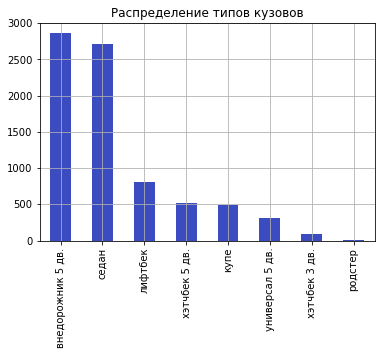

In [10]:
df[field].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение типов кузовов')

<p style="color:green">#############################################################################################</p><br><font size="4">  
<a id='f_02' style="color:blue">2. brand</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_01) | [следующий признак](#f_03)

In [11]:
field = 'brand'
first_look(df,field)

AUDI    7799
Name: brand, dtype: int64

В датасете - 1  разных brand
Пропусков нет


In [12]:
# пока всё хорошо - посмотрим на полном наборе

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_03' style="color:blue">3. car_url</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_02) | [следующий признак](#f_04)

In [13]:
field = 'car_url'
first_look(df,field)

https://auto.ru/cars/used/sale/audi/q5/1105363261-65027897/       12
https://auto.ru/cars/used/sale/audi/a6/1105995943-5540cf22/       12
https://auto.ru/cars/used/sale/audi/a5/1105597924-c0dbb1e7/       12
https://auto.ru/cars/used/sale/audi/q5/1105878870-3cd8e338/       12
https://auto.ru/cars/used/sale/audi/q5/1105948113-9141ad37/       12
                                                                  ..
https://auto.ru/cars/used/sale/audi/a6/1105761665-ebb068be/        1
https://auto.ru/cars/used/sale/audi/q3/1106009088-382a22a5/        1
https://auto.ru/cars/used/sale/audi/rs_q8/1105780694-4dd2217b/     1
https://auto.ru/cars/used/sale/audi/q5/1105618214-ac457d4c/        1
https://auto.ru/cars/used/sale/audi/a6/1078753373-9544/            1
Name: car_url, Length: 1542, dtype: int64

В датасете - 1542  разных car_url
Пропусков нет


In [14]:
# это просто ссылки на объявления, признак не нужен для моделирования
# добавляю в список на удаление
list_of_columns_to_delete.append(field)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_04' style="color:blue">4. color</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_03) | [следующий признак](#f_05)

In [15]:
field = 'color'
first_look(df,field)

чёрный         2688
белый          1795
серый          1061
синий           735
коричневый      450
красный         411
серебристый     172
бежевый          78
оранжевый        77
пурпурный        76
фиолетовый       72
голубой          64
зелёный          64
жёлтый           46
золотистый       10
Name: color, dtype: int64

В датасете - 15  разных color
Пропусков нет


В тестовой выборке 15 цветов, самый популярный черный

<AxesSubplot:title={'center':'Распределение цветов автомобилей'}>

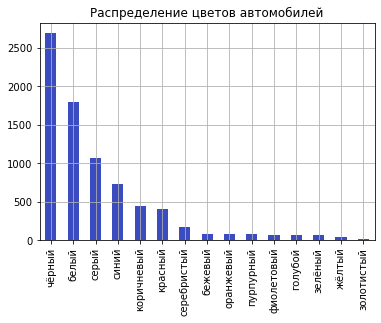

In [17]:
df[field].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение цветов автомобилей')

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_05' style="color:blue">5. complectation_dict</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_04) | [следующий признак](#f_06)

In [18]:
field = 'complectation_dict'
first_look(df,field)

{"id":"0"}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

В датасете - 201  разных complectation_dict
Пропусков нет


признак с информацией о комплектации автомобиля

очень много строчек с значением '{"id":"0"}' - это равносильно пропускам  
скорее всего в финальной выборке надо будет удалять признак

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_06' style="color:blue">6. description</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_05) | [следующий признак](#f_07)

Исходя из названия - это текстовое описание автомобиля от продавца.

In [19]:
field = 'description'
first_look(df,field)

10 000 подарков за покупку автомобиля с пробегом в РОЛЬФ только до 1 декабря!РОЛЬФ | Юго-Восток - это новейший сверхтехнологичный мегамолл по продаже автомобилей с пробегом.Мы предлагаем индивидуальные условия на приобретение Audi с пробегом.Специально для Вас:· Более 1 500 проверенных автомобилей с пробегом на одной площадке.· Более 100 брендов в различных ценовых категориях.· Гарантия от поломок до 2 лет без ограничения по возрасту и пробегу.· Юридическая чистота и безопасность сделки.· Обмен вашего автомобиля на автомобиль с пробегом.· Кредитование в более чем 15 банках-партнёрах (возможна покупка автомобиля в кредит без первоначального взноса).· Страхование КАСКО, ОСАГО на лучших условиях.· Услуги ГИБДД (помощь с постановкой на учет и сохранением государственных знаков).РОЛЬФ Юго-Восток | Автомобили с пробегом. ⭐ №1 по продажам автомобилей с пробегом в России*Мы рады видеть Вас ежедневно с 08:00 до 22:00 по адресу: Москва, МКАД, 27-й километр, вл9*по данным АвтоБизнесРевю          

В датасете - 1282  разных description
Есть пропуски - посмотрим на них


,95,132,143,248,269,278,312,323,428,449,...,6612,6745,7142,7266,7301,7417,7452,7581,7649,7750
bodyType,купе,седан,хэтчбек 3 дв.,купе,седан,седан,седан,хэтчбек 3 дв.,купе,седан,...,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,купе,внедорожник 5 дв.,купе,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.
brand,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,...,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI
car_url,https://auto.ru/cars/used/sale/audi/a5/1105105...,https://auto.ru/cars/used/sale/audi/a4/1105600...,https://auto.ru/cars/used/sale/audi/a3/1106023...,https://auto.ru/cars/used/sale/audi/a5/1105105...,https://auto.ru/cars/used/sale/audi/a6/1105502...,https://auto.ru/cars/used/sale/audi/a4/1104602...,https://auto.ru/cars/used/sale/audi/a4/1105600...,https://auto.ru/cars/used/sale/audi/a3/1106023...,https://auto.ru/cars/used/sale/audi/a5/1105105...,https://auto.ru/cars/used/sale/audi/a6/1105502...,...,https://auto.ru/cars/used/sale/audi/q5/1106060...,https://auto.ru/cars/used/sale/audi/q3/1105882...,https://auto.ru/cars/used/sale/audi/q5/1105833...,https://auto.ru/cars/used/sale/audi/q5/1105833...,https://auto.ru/cars/used/sale/audi/tt/1105819...,https://auto.ru/cars/used/sale/audi/q5/1105833...,https://auto.ru/cars/used/sale/audi/tt/1105819...,https://auto.ru/cars/used/sale/audi/e_tron_spo...,https://auto.ru/cars/used/sale/audi/e_tron_spo...,https://auto.ru/cars/used/sale/audi/e_tron_spo...
color,белый,чёрный,белый,белый,серый,белый,чёрный,белый,белый,серый,...,чёрный,белый,синий,синий,серый,синий,серый,серый,серый,серый
complectation_dict,"{""id"":""0""}","{""id"":""0""}","{""id"":""2428332"",""name"":""Ambition"",""available_o...","{""id"":""0""}","{""id"":""4692009"",""name"":""Стандарт"",""available_o...","{""id"":""2324184"",""name"":""Стандарт"",""available_o...","{""id"":""0""}","{""id"":""2428332"",""name"":""Ambition"",""available_o...","{""id"":""0""}","{""id"":""4692009"",""name"":""Стандарт"",""available_o...",...,"{""id"":""20727628"",""name"":""Базовая"",""available_o...","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}"
description,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
engineDisplacement,2.0 LTR,1.8 LTR,1.4 LTR,2.0 LTR,2.8 LTR,1.8 LTR,1.8 LTR,1.4 LTR,2.0 LTR,2.8 LTR,...,2.0 LTR,2.0 LTR,2.0 LTR,2.0 LTR,2.0 LTR,2.0 LTR,2.0 LTR,LTR,LTR,LTR
enginePower,211 N12,160 N12,125 N12,211 N12,190 N12,160 N12,160 N12,125 N12,211 N12,190 N12,...,230 N12,220 N12,249 N12,249 N12,230 N12,249 N12,230 N12,408 N12,408 N12,408 N12
equipment_dict,"{""cruise-control"":true,""rain-sensor"":true}","{""cruise-control"":true,""tinted-glass"":true,""es...","{""cruise-control"":true,""tinted-glass"":true,""es...","{""cruise-control"":true,""rain-sensor"":true}","{""cruise-control"":true,""tinted-glass"":true,""es...","{""electro-window-back"":true,""ptf"":true,""esp"":t...","{""cruise-control"":true,""tinted-glass"":true,""es...","{""cruise-control"":true,""tinted-glass"":true,""es...","{""cruise-control"":true,""rain-sensor"":true}","{""cruise-control"":true,""tinted-glass"":true,""es...",...,"{""start-stop-function"":true,""esp"":true,""airbag...",{},"{""cruise-control"":true,""tinted-glass"":true,""es...","{""cruise-control"":true,""tinted-glass"":true,""es...",{},"{""cruise-control"":true,""tinted-glass"":true,""es...",{},"{""tinted-glass"":true,""adaptive-light"":true,""sp...","{""tinted-glass"":true,""adaptive-light"":true,""sp...","{""tinted-glass"":true,""adaptive-light"":true,""sp..."
fuelType,бензин,бензин,бензин,бензин,бензин,бензин,бензин,бензин,бензин,бензин,...,бензин,бензин,бензин,бензин,бензин,бензин,бензин,электро,электро,электро


Пропуски есть, но это не так важно поскольку я не силен в анализе текстов придется удалить признак.

In [20]:
df.description[0]

'10 000 подарков за покупку автомобиля с пробегом в РОЛЬФ только до 1 декабря!РОЛЬФ | Юго-Восток - это новейший сверхтехнологичный мегамолл по продаже автомобилей с пробегом.Мы предлагаем индивидуальные условия на приобретение Audi с пробегом.Специально для Вас:· Более 1 500 проверенных автомобилей с пробегом на одной площадке.· Более 100 брендов в различных ценовых категориях.· Гарантия от поломок до 2 лет без ограничения по возрасту и пробегу.· Юридическая чистота и безопасность сделки.· Обмен вашего автомобиля на автомобиль с пробегом.· Кредитование в более чем 15 банках-партнёрах (возможна покупка автомобиля в кредит без первоначального взноса).· Страхование КАСКО, ОСАГО на лучших условиях.· Услуги ГИБДД (помощь с постановкой на учет и сохранением государственных знаков).РОЛЬФ Юго-Восток | Автомобили с пробегом. ⭐ №1 по продажам автомобилей с пробегом в России*Мы рады видеть Вас ежедневно с 08:00 до 22:00 по адресу: Москва, МКАД, 27-й километр, вл9*по данным АвтоБизнесРевю'

<b>Пока запишу здесь, что можно поработать с текстом и получить уникальные признаки - отличающие автомобиль от других.
Но мои навыки в этом небольшие, оставлю прозапас, если будет время этим можно заняться.</b>

А пока удаляем((

In [21]:
# можно сделать пару новых признаков: есть/нету описания и длина описания.
df['description_bool'] = df.description.apply(lambda x: 1 if len(str(x))>0 else 0)
df['description_length'] = df.description.apply(lambda x: len(str(x)))

In [22]:
# вносим в список признаков на удаление
list_of_columns_to_delete.append(field)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_07' style="color:blue">7. engineDisplacement</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_06) | [следующий признак](#f_08)

In [23]:
field = 'engineDisplacement'
first_look(df,field)

2.0 LTR    3277
3.0 LTR    1822
1.4 LTR     962
1.8 LTR     702
2.8 LTR     256
4.0 LTR     217
1.2 LTR     138
4.2 LTR     114
2.5 LTR      93
3.2 LTR      63
 LTR         30
6.3 LTR      22
3.6 LTR      21
4.1 LTR      21
5.9 LTR      19
2.9 LTR      18
5.2 LTR      14
1.5 LTR       6
2.7 LTR       4
Name: engineDisplacement, dtype: int64

В датасете - 19  разных engineDisplacement
Пропусков нет


Признак объема двигателя с добавкой "LTR" - скорее всего это сокращение от "liter"

И хотя пропусков формально нет, но " LTR" по факту таким является.
Надо будет заменить это значение на наиболее часто встречающееся.

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_08' style="color:blue">8. enginePower</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_07) | [следующий признак](#f_09)

In [24]:
field = 'enginePower'
first_look(df,field)

249 N12    1043
170 N12     666
225 N12     608
180 N12     584
211 N12     507
190 N12     453
245 N12     425
150 N12     422
122 N12     405
310 N12     249
333 N12     221
230 N12     204
204 N12     187
300 N12     183
125 N12     178
340 N12     123
177 N12     118
160 N12      99
120 N12      87
105 N12      85
450 N12      81
290 N12      79
560 N12      77
220 N12      70
272 N12      65
372 N12      57
435 N12      53
110 N12      53
239 N12      45
500 N12      41
270 N12      32
271 N12      31
238 N12      27
422 N12      22
280 N12      21
420 N12      20
250 N12      19
408 N12      18
520 N12      17
354 N12      17
367 N12      15
525 N12      14
600 N12      13
400 N12      11
143 N12      10
218 N12       9
605 N12       8
252 N12       6
313 N12       5
286 N12       5
646 N12       4
530 N12       3
200 N12       3
571 N12       1
Name: enginePower, dtype: int64

В датасете - 54  разных enginePower
Пропусков нет


Признак мощности автомобиля

In [25]:
# проверю есть ли "пропуски" аналогичные engineDisplacement
if len(df[df[field]==' N12']) == 0:
    print('аналогичных пропусков нету')
else:
    print('такие пропуски есть')

аналогичных пропусков нету


<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_09' style="color:blue">9. equipment_dict</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_08) | [следующий признак](#f_10)

In [26]:
field = 'equipment_dict'
first_look(df,field)

{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

В датасете - 1326  разных equipment_dict
Пропусков нет


Я посмотрел в тестовой выборке (test.csv) из 34686 записей 23706 уникальных записей и 9996 пустых значений.  
поскольку пропуски приближаются к 1/3, а в текущем файле к 1/5 - к поле надо исключать из моделирования.

In [27]:
# вносим в список признаков на удаление
list_of_columns_to_delete.append(field)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_10' style="color:blue">10. fuelType</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_09) | [следующий признак](#f_11)

In [28]:
field = 'fuelType'
first_look(df,field)

бензин     6333
дизель     1429
электро      30
гибрид        7
Name: fuelType, dtype: int64

В датасете - 4  разных fuelType
Пропусков нет


<AxesSubplot:title={'center':'Распределение автомобилей по типу топлива'}>

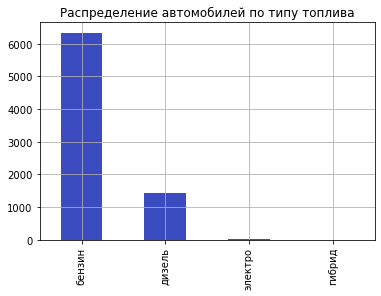

In [29]:
df[field].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей по типу топлива')

Признак содержит информацию о типе потребляемого топлива автомобилем.  
Лидирующий тип - бензин.

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_11' style="color:blue">11. image</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_10) | [следующий признак](#f_12)

In [30]:
field = 'image'
first_look(df,field)

NaN                                                                                                                                                                                                                                                                                                             349
//autoru.naydex.net/1fX4JC520/7d8bb7Lqf/hM8Q5BnTuQSszrah4gpwwg7WSI3UyjgGrwQCfXy19-yt5fbs5EABn9ATonla1jIWMaqDhyGgjMdO5KNWKJmLq43HGeV4wqF8iZOvjMtbdZdT9jDUpdpEIkepsv2gGXdsXE0KaK0pBPetPqvY7urLw8Du0gLlCVR-P8FuR-n1j2s4H1xcmYNouNTux92eluBq1tP05RATMApnSSbJiAX_sDRJymQFeQSGSSqnQJ_GM9MIYham7WWASsdBelNp_W_zxCc8     10
//autoru.naydex.net/1fX4JC520/7d8bb7Lqf/hM8Q5BnTuQSszrah4gpwwg7WSI3UyjgGrwQCfXy19-yt5fbs5EABm_AnrkVW13dLbZP7sy24hZt--JN6IJjHpt3OVelJgrAxyYO7nZdXdZdT9jDUpdpEIkepsv2gGXdsXE0KaK0pBPetPqvY7urLw8Du0gLlCVR-P8FuR-n1j2s4H1xcmYNouNTux92eluBq1tP05RATMApnSSbJiAX_sDRJymQFeQSGSSqnQJ_GM9MIYham7WWASsdBelNp_W_zxCc8     10
//avatars.mds.yandex.net/get-autoru-vos/4944617/508c081ba482b36d6b949feb1131

В датасете - 2635  разных image
Есть пропуски - посмотрим на них


,14,32,73,126,129,144,166,184,225,285,...,7643,7674,7679,7681,7713,7734,7744,7775,7780,7782
bodyType,седан,внедорожник 5 дв.,универсал 5 дв.,внедорожник 5 дв.,купе,внедорожник 5 дв.,седан,внедорожник 5 дв.,универсал 5 дв.,седан,...,лифтбек,внедорожник 5 дв.,внедорожник 5 дв.,седан,внедорожник 5 дв.,седан,лифтбек,внедорожник 5 дв.,внедорожник 5 дв.,седан
brand,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,...,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI
car_url,https://auto.ru/cars/used/sale/audi/a6/1105752...,https://auto.ru/cars/used/sale/audi/q5/1105881...,https://auto.ru/cars/used/sale/audi/allroad/11...,https://auto.ru/cars/used/sale/audi/q5/1102919...,https://auto.ru/cars/used/sale/audi/a5/1105881...,https://auto.ru/cars/used/sale/audi/q5/1105969...,https://auto.ru/cars/used/sale/audi/a6/1105752...,https://auto.ru/cars/used/sale/audi/q5/1105881...,https://auto.ru/cars/used/sale/audi/allroad/11...,https://auto.ru/cars/used/sale/audi/a6/1105014...,...,https://auto.ru/cars/used/sale/audi/a7/1105700...,https://auto.ru/cars/used/sale/audi/q7/1105807...,https://auto.ru/cars/used/sale/audi/q7/1105815...,https://auto.ru/cars/used/sale/audi/a4/1105833...,https://auto.ru/cars/used/sale/audi/q5/1105552...,https://auto.ru/cars/used/sale/audi/a4/1105715...,https://auto.ru/cars/used/sale/audi/a7/1105700...,https://auto.ru/cars/used/sale/audi/q7/1105807...,https://auto.ru/cars/used/sale/audi/q7/1105815...,https://auto.ru/cars/used/sale/audi/a4/1105833...
color,чёрный,коричневый,белый,чёрный,белый,серый,чёрный,коричневый,белый,белый,...,синий,чёрный,чёрный,серый,чёрный,белый,синий,чёрный,чёрный,серый
complectation_dict,"{""id"":""6937691"",""name"":""Базовая"",""available_op...","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""4693613"",""name"":""Базовая"",""available_op...","{""id"":""0""}","{""id"":""6937691"",""name"":""Базовая"",""available_op...","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}",...,"{""id"":""21649591"",""name"":""Sport 45 TFSI quattro...","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""21649591"",""name"":""Sport 45 TFSI quattro...","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}"
description,"Машина в хорошем состоянии. Ничего не стучит, ...","Продает собственник. Пробег оригинальный, подт...","Продаю личный автомобиль,за машину не стыдно,о...",Продам прекрасный автомобиль. Полностью обслуж...,"По технике в отличном состоянии, полностью об...",Занимаюсь купли-продажей автомобилей с пробего...,"Машина в хорошем состоянии. Ничего не стучит, ...","Продает собственник. Пробег оригинальный, подт...","Продаю личный автомобиль,за машину не стыдно,о...","Дизель 3 литра Quattro, динамичное комфортное ...",...,Автомобиль представлен ГК Авто Премиум (официа...,10 000 подарков за покупку автомобиля с пробег...,10 000 подарков за покупку автомобиля с пробег...,10 000 подарков за покупку автомобиля с пробег...,10 000 подарков за покупку автомобиля с пробег...,10 000 подарков за покупку автомобиля с пробег...,Автомобиль представлен ГК Авто Премиум (официа...,10 000 подарков за покупку автомобиля с пробег...,10 000 подарков за покупку автомобиля с пробег...,10 000 подарков за покупку автомобиля с пробег...
engineDisplacement,2.8 LTR,2.0 LTR,3.0 LTR,2.0 LTR,2.0 LTR,2.0 LTR,2.8 LTR,2.0 LTR,3.0 LTR,3.0 LTR,...,2.0 LTR,3.0 LTR,3.0 LTR,2.0 LTR,2.0 LTR,2.0 LTR,2.0 LTR,3.0 LTR,3.0 LTR,2.0 LTR
enginePower,204 N12,211 N12,290 N12,211 N12,211 N12,211 N12,204 N12,211 N12,290 N12,245 N12,...,245 N12,249 N12,249 N12,190 N12,249 N12,249 N12,245 N12,249 N12,249 N12,190 N12
equipment_dict,"{""asr"":true,""esp"":true,""usb"":true,""multi-wheel...",{},"{""cruise-control"":true,""asr"":true,""tinted-glas...","{""electro-window-back"":true,""asr"":true,""tinted...","{""engine-proof"":true,""esp"":true,""airbag-driver...","{""cruise-control"":true,""asr"":true,""esp"":true,""...","{""asr"":true,""esp"":true,""usb"":true,""multi-wheel...",{},"{""cruise-control"":true,""asr"":tr

Есть пропуски - надо сделать новый признак есть ли картинка в объявлении.
Больше смысла от признака я не вижу.

In [31]:
# добавляю в список на исключение признака
list_of_columns_to_delete.append(field)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_12' style="color:blue">12. mileage</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_11) | [следующий признак](#f_13)

Признак содержит информацию о пробеге автомобиля.

In [32]:
field = 'mileage'
first_look(df,field)

125000.0    54
120000.0    54
140000.0    53
130000.0    46
160000.0    45
            ..
2500.0       1
18000.0      1
259000.0     1
102500.0     1
6800.0       1
Name: mileage, Length: 1043, dtype: int64

В датасете - 1043  разных mileage
Пропусков нет


только в части данных содержится 1043 уникальных значений.  
Надо разбить признак на группы.

In [33]:
step = np.arange(0, 500000, 25000)
df.groupby(pd.cut(df.mileage, step)).car_price.median()

mileage
(0, 25000]          4610320.0
(25000, 50000]      2775000.0
(50000, 75000]      2196000.0
(75000, 100000]     1999000.0
(100000, 125000]    1606000.0
(125000, 150000]    1397000.0
(150000, 175000]    1479000.0
(175000, 200000]    1280000.0
(200000, 225000]    1300000.0
(225000, 250000]    1600000.0
(250000, 275000]    1499000.0
(275000, 300000]    1400400.0
(300000, 325000]    1635000.0
(325000, 350000]    1200000.0
(350000, 375000]     620000.0
(375000, 400000]          NaN
(400000, 425000]          NaN
(425000, 450000]          NaN
(450000, 475000]          NaN
Name: car_price, dtype: float64

In [34]:
df.mileage.describe()

count      7799.000000
mean     111754.738556
std       56363.757490
min          11.000000
25%       74273.000000
50%      113144.000000
75%      147708.000000
max      370000.000000
Name: mileage, dtype: float64

In [35]:
# попробуем посмотреть по числу владельцев

# приведем сначала признак "Владельцы" к числовому
try:
    df['Владельцы'] = df['Владельцы'].apply(lambda x: x if type(x) == float else int(x[0]))
except:
    pass

df.groupby(pd.cut(df.mileage, step)).Владельцы.median()

mileage
(0, 25000]          1.0
(25000, 50000]      1.0
(50000, 75000]      2.0
(75000, 100000]     2.0
(100000, 125000]    2.0
(125000, 150000]    2.0
(150000, 175000]    3.0
(175000, 200000]    3.0
(200000, 225000]    3.0
(225000, 250000]    2.0
(250000, 275000]    1.0
(275000, 300000]    2.0
(300000, 325000]    3.0
(325000, 350000]    2.0
(350000, 375000]    3.0
(375000, 400000]    NaN
(400000, 425000]    NaN
(425000, 450000]    NaN
(450000, 475000]    NaN
Name: Владельцы, dtype: float64

In [36]:
df['Владельцы'].value_counts(dropna=False)

3    2825
2    2503
1    2471
Name: Владельцы, dtype: int64

Получается будем бить на 4 группы: 0-50'000, 50'000-150'000, 150'000-300'000 и все остальные.  

<b>ВАЖНО! сначала делаем предобработку данных, и потом уже генерируем новые признаки.  
Иначе будут кривые новые признаки.</b>

In [37]:
mileage_borders = [0, 50000, 150000,300000]
df["mileage_group"] = df["mileage"].apply(lambda x: 3 if x>=mileage_borders[3] 
                                               else(2 if x>=mileage_borders[2] 
                                               else(1 if x>=mileage_borders[1] else 0)))

<AxesSubplot:title={'center':'Распределение автомобилей на группы по пробегу'}>

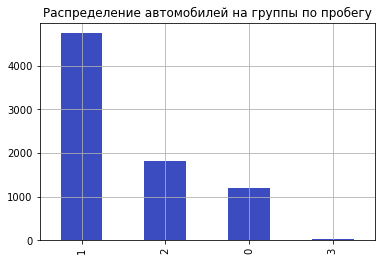

In [39]:
df["mileage_group"].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей на группы по пробегу')

Получается в нашей маленькой выборке больше всего автомобилей с пробегом группы 1 (сам пробег в диапазоне 50'000-150'000 км)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_13' style="color:blue">13. modelDate</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_12) | [следующий признак](#f_14)

Признак содержит дату выхода модели (не путать с годом выпуска автомобиля "productionDate")

In [40]:
field = 'modelDate'
first_look(df,field)

2012.0    1171
2013.0    1133
2014.0    1092
2015.0     985
2016.0     830
2011.0     598
2017.0     596
2010.0     428
2018.0     352
2019.0     288
2021.0     165
2020.0     161
Name: modelDate, dtype: int64

В датасете - 12  разных modelDate
Пропусков нет



<b>ВАЖНО! сначала делаем предобработку данных, и потом уже генерируем новые признаки.  
Иначе будут кривые новые признаки.</b>

In [41]:
# тоже можно добавить группу по году модели
# сделаю также 4 группы: 2020-2021, 2017-2020, 2011-2017 и остальные 
# получается группы (новые, хорошие, побегавшие и старые)

modelDate_borders = [2011, 2017, 2020]
modelDate_borders_names = ['старые', 'побегавшие', 'хорошие','новые']

df["modelDate_group"] = df["modelDate"].apply(lambda x: 3 if x>=modelDate_borders[2] 
                                                   else(2 if x>=modelDate_borders[1] 
                                                   else(1 if x>=modelDate_borders[0] else 0)))

<AxesSubplot:title={'center':'Распределение автомобилей на группы по году модели'}>

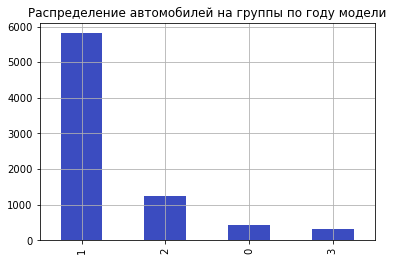

In [42]:
df["modelDate_group"].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей на группы по году модели')

Получается в нашей маленькой выборке больше всего автомобилей с пробегом группы 1 (модель выпущена в продажу в 2017-2020 годах)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_14' style="color:blue">14. model_info</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_13) | [следующий признак](#f_15)

Признак с информацией о модели автомобиля

In [43]:
field = 'model_info'
first_look(df,field)

{"code":"Q5","name":"Q5","ru_name":"Ку5","morphology":{}                                            1160
{"code":"A6","name":"A6","ru_name":"А6","morphology":{}                                             1071
{"code":"A4","name":"A4","ru_name":"А4","morphology":{}                                             1021
{"code":"Q7","name":"Q7","ru_name":"Ку7","morphology":{}                                             836
{"code":"A3","name":"A3","ru_name":"А3","morphology":{}                                              719
{"code":"Q3","name":"Q3","ru_name":"Ку3","morphology":{}                                             674
{"code":"A5","name":"A5","ru_name":"А5","morphology":{}                                              603
{"code":"A7","name":"A7","ru_name":"А7","morphology":{}                                              426
{"code":"A8","name":"A8","ru_name":"А8","morphology":{}                                              331
{"code":"A1","name":"A1","ru_name":"А1","morphology":{}

В датасете - 38  разных model_info
Пропусков нет


Странный признак, содержит уже имеющуюся информацию.  
Похоже надо удалять признак.  

In [44]:
# добавляю в список на исключение признака
list_of_columns_to_delete.append(field)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_15' style="color:blue">15. model_name</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_14) | [следующий признак](#f_16)

In [45]:
field = 'model_name'
first_look(df,field)

NaN    7799
Name: model_name, dtype: int64

В датасете - 0  разных model_name
Есть пропуски - посмотрим на них


,0,2,3,4,5,6,7,8,9,10,...,7796,7797,7798,7799,7800,7801,7802,7803,7804,7805
bodyType,лифтбек,седан,лифтбек,внедорожник 5 дв.,седан,внедорожник 5 дв.,седан,хэтчбек 3 дв.,седан,купе,...,седан,седан,внедорожник 5 дв.,универсал 5 дв.,внедорожник 5 дв.,седан,внедорожник 5 дв.,седан,седан,седан
brand,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,...,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI
car_url,https://auto.ru/cars/used/sale/audi/a7/1106066...,https://auto.ru/cars/used/sale/audi/a6/1106053...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/a6/1106067...,https://auto.ru/cars/used/sale/audi/q7/1106058...,https://auto.ru/cars/used/sale/audi/a4/1106020...,https://auto.ru/cars/used/sale/audi/a1/1105607...,https://auto.ru/cars/used/sale/audi/a4/1106053...,https://auto.ru/cars/used/sale/audi/a5/1105980...,...,https://auto.ru/cars/used/sale/audi/s8/1105782...,https://auto.ru/cars/used/sale/audi/a6/1105710...,https://auto.ru/cars/used/sale/audi/rs_q8/1105...,https://auto.ru/cars/used/sale/audi/rs6/110572...,https://auto.ru/cars/used/sale/audi/q7/1105807...,https://auto.ru/cars/used/sale/audi/a3/1105890...,https://auto.ru/cars/used/sale/audi/q5/1105932...,https://auto.ru/cars/used/sale/audi/a4/1105841...,https://auto.ru/cars/used/sale/audi/a3/1105805...,https://auto.ru/cars/used/sale/audi/a3/1105870...
color,чёрный,чёрный,чёрный,белый,синий,серый,серый,фиолетовый,серый,белый,...,чёрный,чёрный,чёрный,серый,белый,серый,серый,белый,белый,красный
complectation_dict,"{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""2324184"",""name"":""Стандарт"",""available_o...","{""id"":""0""}","{""id"":""0""}","{""id"":""6453974"",""name"":""Базовая"",""available_op...",...,"{""id"":""21877514"",""name"":""TFSI quattro tiptroni...","{""id"":""21594402"",""name"":""Design 45 TFSI quattr...","{""id"":""0""}","{""id"":""22758824"",""name"":""TFSI quattro"",""availa...","{""id"":""21905403"",""name"":""45 TDI quattro tiptro...","{""id"":""20838807"",""name"":""Basis"",""available_opt...","{""id"":""0""}","{""id"":""0""}","{""id"":""20838807"",""name"":""Basis"",""available_opt...","{""id"":""0""}"
description,10 000 подарков за покупку автомобиля с пробег...,Максимальная комплектация. Полный привод. Факт...,10 000 подарков за покупку автомобиля с пробег...,ЛОТ: 01296707Локация №11Volvo Car КоптевоСкидк...,Фактических 2 владельца. Первый владелец идет ...,10 000 подарков за покупку автомобиля с пробег...,Автомобиль в отличном состоянии. Без ДТП.Макси...,Фактически два владельца. Была перерегистрация...,"!!!Цена всего на 3 дня (26-28 декабря), дальше...",Продаю Audi A5 1.8 в отличном состоянии. -Ус...,...,Осмотр в Москве.Код предложения: 8847/2021ПТС ...,Автомобиль продается по программе сертифициров...,10 000 подарков за покупку автомобиля с пробег...,Состояние нового автомобиля!! Машина покрыта к...,"""В продаже сертифицированный Audi Q7 с пробего...","Состояние нового авто, 09.2021 пройдено ТО. Фа...",Комплектация S-Line.Аудиосистема Bang and Oluf...,Состояние нового автомобиля.На гарантии до 11....,"Автомобиль в состоянии нового Авто, в салоне н...","Состояние нового автомобиля(09.2020), любые пр..."
engineDisplacement,3.0 LTR,3.0 LTR,3.0 LTR,2.0 LTR,3.0 LTR,3.0 LTR,2.0 LTR,1.4 LTR,2.0 LTR,1.8 LTR,...,4.0 LTR,2.0 LTR,4.0 LTR,4.0 LTR,3.0 LTR,1.4 LTR,2.0 LTR,2.0 LTR,1.4 LTR,1.4 LTR
enginePower,300 N12,300 N12,300 N12,211 N12,245 N12,272 N12,211 N12,122 N12,211 N12,160 N12,...,571 N12,245 N12,600 N12,600 N12,249 N12,150 N12,249 N12,150 N12,150 N12,150 N12
equipment_dict,"{""cruise-control"":true,""engine-proof"":true,""as...","{""cruise-control"":true,""asr"":true,""tinted-glas...","{""cruise-control"":true,""asr"":true,""tinted-glas...","{""cruise-control"":true,""asr"":true,""esp"":true,""...","{""cruise-control"":true,""asr"":true,""tinted-glas...","{""cruise-control"":true,""asr"":true,""tinted-gl

а вот и пригодился предыдущий признак - заполним текущее поле из предыдущего.

In [46]:
# поправим сначала сам признак - там потеряна зарывающая '}'
df['model_info'] = df['model_info'].apply(lambda x: x + str('}'))

In [47]:
# теперь получим наименование модели
df['model_name'] = df['model_info'].apply(lambda x: json.loads(x)['name'])

In [48]:
# посмотрим еще раз на признак
first_look(df,field)

Q5                  1160
A6                  1071
A4                  1021
Q7                   836
A3                   719
Q3                   674
A5                   603
A7                   426
A8                   331
A1                   174
A6 allroad           124
TT                    93
RS 5                  68
Q8                    67
RS 7                  59
A4 allroad            55
RS Q3                 46
RS 3                  36
RS 6                  34
SQ7                   29
S5                    24
e-tron                20
S8                    18
TTS                   16
R8                    14
S3                    13
TT RS                 11
S6                    10
RS 4                   7
S7                     6
Q3 Sportback           6
SQ5                    6
RS Q8                  5
RS e-tron GT           4
Q5 Sportback           4
e-tron Sportback       3
SQ8                    3
e-tron GT              3
Name: model_name, dtype: int64

В датасете - 38  разных model_name
Пропусков нет


<AxesSubplot:title={'center':'Распределение автомобилей по модели'}>

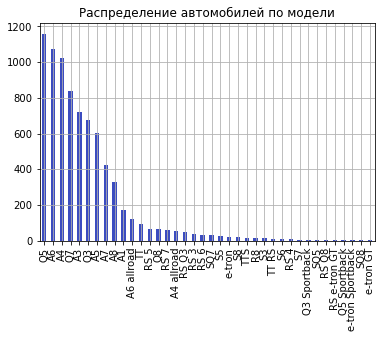

In [49]:
df[field].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей по модели')

Отлично)))

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_16' style="color:blue">16. name</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_15) | [следующий признак](#f_17)

In [50]:
field = 'name'
first_look(df,field)

3.0dAT (249л.с.)                 529
2.0AMT (249л.с.)                 514
2.0AMT (211л.с.)                 440
2.0AT (225л.с.)                  418
1.4AMT (122л.с.)                 397
                                ... 
ElectroAT (530л.с. / 390л.с.)      3
2.0AMT (200л.с.)                   2
3.0dAMT (204л.с.)                  1
4.0AT (571л.с.)                    1
2.0AT (200л.с.)                    1
Name: name, Length: 105, dtype: int64

В датасете - 105  разных name
Пропусков нет


В исходном датасете разделены объем двигателя и код коробки - разделим их обратно (я при парсинге удалял пробелы видимо тут не надо было этого делать)

In [51]:
# функция разделения объемы двигателя и кода коробки передач
def change_name(x):
    list_of_change = ['AT','MT','AMT','CVT']

    if list_of_change[1] in x and list_of_change[2] in x:
        x = x.replace(list_of_change[2],' ' + list_of_change[2])
    for item in list_of_change:
        if list_of_change[0] in x or list_of_change[3] in x:
            x = x.replace(item,' ' + item)
        elif list_of_change[1] in x and list_of_change[2] not in x:
            x = x.replace(item,' ' + item)
        else:
            pass
    
    return x

# применим функцию разделения
df[field] = df[field].apply(lambda x: change_name(x))

In [52]:
# Проверим результат разделения
list_of_un_names = df[field].unique()
list_first_part=[]
for item in list_of_un_names:
    frst = item.split(' ')[1]
    if frst not in list_first_part:
        list_first_part.append(frst)
        
print('Выделены коробки:',list_first_part)
print('Список уникальных names:',list_of_un_names)

Выделены коробки: ['AMT', 'AT', 'CVT', 'MT']
Список уникальных names: ['3.0 AMT (300л.с.)' '2.0 AMT (211л.с.)' '3.0d AMT (245л.с.)'
 '3.0 AT (272л.с.)' '2.0 CVT (211л.с.)' '1.4 AMT (122л.с.)'
 '1.8 CVT (160л.с.)' '3.0d AT (250л.с.)' '4.2 AT (372л.с.)'
 '2.8 AMT (204л.с.)' '3.0d AT (239л.с.)' '1.4 AMT (125л.с.)'
 '3.6 AT (280л.с.)' '2.0 CVT (180л.с.)' '3.0 AT (333л.с.)'
 '1.8 AMT (160л.с.)' '2.0 MT (180л.с.)' '1.8 CVT (120л.с.)'
 '3.0d AT (238л.с.)' '3.0 AT (290л.с.)' '1.8 MT (160л.с.)'
 '2.0d CVT (143л.с.)' '2.0 CVT (170л.с.)' '5.9d AT (500л.с.)'
 '3.0d AMT (239л.с.)' '2.0d AMT (170л.с.)' '4.2 AMT (450л.с.)'
 '3.0d AT (245л.с.)' '2.0 AT (211л.с.)' '4.1d AT (340л.с.)'
 '5.2 AMT (525л.с.)' '2.8 AT (220л.с.)' '2.8 CVT (190л.с.)'
 '1.2 AMT (105л.с.)' '2.7d CVT (190л.с.)' '3.2 AMT (270л.с.)'
 '6.3 AT (500л.с.)' '2.0 AMT (200л.с.)' '2.0 AT (225л.с.)'
 '3.0 AMT (310л.с.)' '1.8 CVT (170л.с.)' '2.0 AMT (170л.с.)'
 '3.2 AT (271л.с.)' '3.0 AMT (272л.с.)' '2.0 AMT (225л.с.)'
 '1.8 AMT (180л.с.)' '

In [53]:
# запустим просмотр поля еще раз
first_look(df,field)

3.0d AT (249л.с.)                 529
2.0 AMT (249л.с.)                 514
2.0 AMT (211л.с.)                 440
2.0 AT (225л.с.)                  418
1.4 AMT (122л.с.)                 397
                                 ... 
Electro AT (530л.с. / 390л.с.)      3
2.0 AMT (200л.с.)                   2
3.0d AMT (204л.с.)                  1
2.0 AT (200л.с.)                    1
4.0 AT (571л.с.)                    1
Name: name, Length: 105, dtype: int64

В датасете - 105  разных name
Пропусков нет


Теперь признак похож на признак в тестовой выборке))

Очень много вариаций, надо выделить признаки объем двигателя и его мощность - их сгруппировать при необходимости.  
А текущий признак удалить.

In [54]:
def get_param_engine(x):
    try:
        vol = round(int(json.loads(x)['displacement'])/1000,1)
    except:
        vol = np.NaN
    
    try:
        pwr = int(json.loads(x)['power'])
    except:
        pwr = np.NaN
    
    return vol,pwr
    

In [55]:
df['engine_volume'] = df['super_gen'].apply(lambda x: get_param_engine(x)[0])
df['engine_power'] = df['super_gen'].apply(lambda x: get_param_engine(x)[1])

<AxesSubplot:title={'center':'Распределение автомобилей по объему двигателя'}>

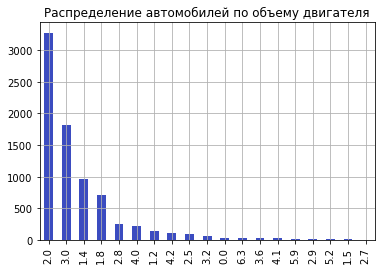

In [56]:
df['engine_volume'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей по объему двигателя')

<AxesSubplot:title={'center':'Распределение автомобилей по мощности двигателя'}>

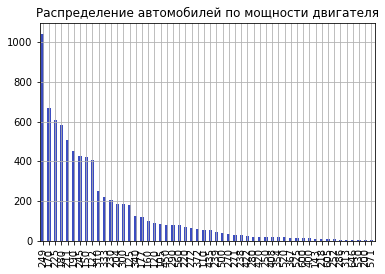

In [57]:
df['engine_power'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей по мощности двигателя')

На текущих данных самый популярный двигатель имеет объем 2 литра и самая популярная мощность 249 лс.


<b>ВАЖНО! сначала делаем предобработку данных, и потом уже генерируем новые признаки.  
Иначе будут кривые новые признаки.</b>

In [58]:
# тоже можно добавить группу по объему двигателя
# сделаю также группы: -2,2-3,3-4,4-5 и остальные 
engine_volume_borders = [2, 3, 4, 5]

df["engine_volume_group"] = df["engine_volume"].apply(lambda x: 4 if x>=engine_volume_borders[3] 
                                                           else(3 if x>=engine_volume_borders[2] 
                                                           else(2 if x>=engine_volume_borders[1] 
                                                           else(1 if x>=engine_volume_borders[0] else 0))))

<AxesSubplot:title={'center':'Распределение автомобилей по группам объема двигателя'}>

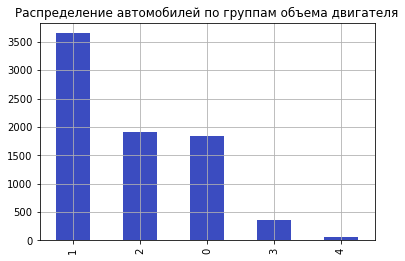

In [59]:
df['engine_volume_group'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей по группам объема двигателя')

Самая популярная группа 1 (объем двигателей 2-3 литра)

In [60]:
# тоже можно добавить группу по мощности двигателя
# сделаю также группы: -150,150-250,250-350,350-450 и остальные 
engine_power_borders = [150, 250, 350, 450]

df["engine_power_group"] = df["engine_power"].apply(lambda x: 4 if x>=engine_power_borders[3] 
                                                           else(3 if x>=engine_power_borders[2] 
                                                           else(2 if x>=engine_power_borders[1] 
                                                           else(1 if x>=engine_power_borders[0] else 0))))

<AxesSubplot:title={'center':'Распределение автомобилей по группам мощности двигателя'}>

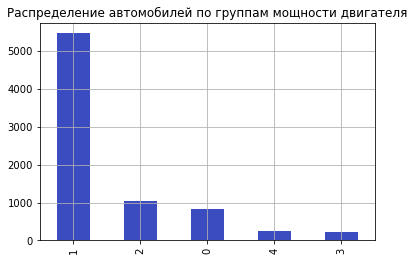

In [61]:
df['engine_power_group'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей по группам мощности двигателя')

Самая популярная группа 1 (мощность двигателей 150-250 лс)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_17' style="color:blue">17. numberOfDoors</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_16) | [следующий признак](#f_18)

Признак содержит информацию о числе дверей у автомобиля

In [62]:
field = 'numberOfDoors'
first_look(df,field)

5    4494
4    2710
2     507
3      88
Name: numberOfDoors, dtype: int64

В датасете - 4  разных numberOfDoors
Пропусков нет


<AxesSubplot:title={'center':'Распределение автомобилей по числу дверей'}>

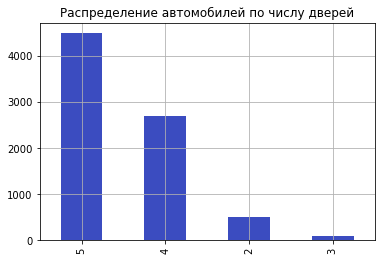

In [63]:
df['numberOfDoors'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей по числу дверей')

В тестовой выборке есть машина без дверей)))))  
Видимо это машина из будущего - туда телепортируются)))  
<b>Надо потом удалить в тестовой выборке эту запись.</b>

ПС. Я заполнил пропуски наиболее частым значением.

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_18' style="color:blue">18. parsing_unixtime</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_17) | [следующий признак](#f_19)

Признак содержит дату и время парсинга, я для тренировочного сета ставил время самого парсинга.

In [64]:
field = 'parsing_unixtime'
first_look(df,field)

1.637958e+09    1
1.637963e+09    1
1.637959e+09    1
1.637958e+09    1
1.637958e+09    1
               ..
1.637974e+09    1
1.637979e+09    1
1.637972e+09    1
1.637961e+09    1
1.637974e+09    1
Name: parsing_unixtime, Length: 7799, dtype: int64

В датасете - 7799  разных parsing_unixtime
Пропусков нет


Самая ранняя дата в тестовой выборке:  2020-10-19 11:35:06  
Самая поздняя дата в тестовой выборке: 2020-10-26 11:04:24

Те парсинг тестового датасета происходил с 19 по 26 октября 2020 года.
Буду это использовать при расчетах - надо будет добавить изменение курса с тех времен или добавить инфляцию...
Знание периода парсинга поможет решить эту проблему.

In [65]:
# признак не нужен - добавляю в список на удаление
list_of_columns_to_delete.append(field)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_19' style="color:blue">19. priceCurrency</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_18) | [следующий признак](#f_20)

In [66]:
field = 'priceCurrency'
first_look(df,field)

NaN    7799
Name: priceCurrency, dtype: int64

В датасете - 0  разных priceCurrency
Есть пропуски - посмотрим на них


,0,2,3,4,5,6,7,8,9,10,...,7796,7797,7798,7799,7800,7801,7802,7803,7804,7805
bodyType,лифтбек,седан,лифтбек,внедорожник 5 дв.,седан,внедорожник 5 дв.,седан,хэтчбек 3 дв.,седан,купе,...,седан,седан,внедорожник 5 дв.,универсал 5 дв.,внедорожник 5 дв.,седан,внедорожник 5 дв.,седан,седан,седан
brand,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,...,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI
car_url,https://auto.ru/cars/used/sale/audi/a7/1106066...,https://auto.ru/cars/used/sale/audi/a6/1106053...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/a6/1106067...,https://auto.ru/cars/used/sale/audi/q7/1106058...,https://auto.ru/cars/used/sale/audi/a4/1106020...,https://auto.ru/cars/used/sale/audi/a1/1105607...,https://auto.ru/cars/used/sale/audi/a4/1106053...,https://auto.ru/cars/used/sale/audi/a5/1105980...,...,https://auto.ru/cars/used/sale/audi/s8/1105782...,https://auto.ru/cars/used/sale/audi/a6/1105710...,https://auto.ru/cars/used/sale/audi/rs_q8/1105...,https://auto.ru/cars/used/sale/audi/rs6/110572...,https://auto.ru/cars/used/sale/audi/q7/1105807...,https://auto.ru/cars/used/sale/audi/a3/1105890...,https://auto.ru/cars/used/sale/audi/q5/1105932...,https://auto.ru/cars/used/sale/audi/a4/1105841...,https://auto.ru/cars/used/sale/audi/a3/1105805...,https://auto.ru/cars/used/sale/audi/a3/1105870...
color,чёрный,чёрный,чёрный,белый,синий,серый,серый,фиолетовый,серый,белый,...,чёрный,чёрный,чёрный,серый,белый,серый,серый,белый,белый,красный
complectation_dict,"{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""2324184"",""name"":""Стандарт"",""available_o...","{""id"":""0""}","{""id"":""0""}","{""id"":""6453974"",""name"":""Базовая"",""available_op...",...,"{""id"":""21877514"",""name"":""TFSI quattro tiptroni...","{""id"":""21594402"",""name"":""Design 45 TFSI quattr...","{""id"":""0""}","{""id"":""22758824"",""name"":""TFSI quattro"",""availa...","{""id"":""21905403"",""name"":""45 TDI quattro tiptro...","{""id"":""20838807"",""name"":""Basis"",""available_opt...","{""id"":""0""}","{""id"":""0""}","{""id"":""20838807"",""name"":""Basis"",""available_opt...","{""id"":""0""}"
description,10 000 подарков за покупку автомобиля с пробег...,Максимальная комплектация. Полный привод. Факт...,10 000 подарков за покупку автомобиля с пробег...,ЛОТ: 01296707Локация №11Volvo Car КоптевоСкидк...,Фактических 2 владельца. Первый владелец идет ...,10 000 подарков за покупку автомобиля с пробег...,Автомобиль в отличном состоянии. Без ДТП.Макси...,Фактически два владельца. Была перерегистрация...,"!!!Цена всего на 3 дня (26-28 декабря), дальше...",Продаю Audi A5 1.8 в отличном состоянии. -Ус...,...,Осмотр в Москве.Код предложения: 8847/2021ПТС ...,Автомобиль продается по программе сертифициров...,10 000 подарков за покупку автомобиля с пробег...,Состояние нового автомобиля!! Машина покрыта к...,"""В продаже сертифицированный Audi Q7 с пробего...","Состояние нового авто, 09.2021 пройдено ТО. Фа...",Комплектация S-Line.Аудиосистема Bang and Oluf...,Состояние нового автомобиля.На гарантии до 11....,"Автомобиль в состоянии нового Авто, в салоне н...","Состояние нового автомобиля(09.2020), любые пр..."
engineDisplacement,3.0 LTR,3.0 LTR,3.0 LTR,2.0 LTR,3.0 LTR,3.0 LTR,2.0 LTR,1.4 LTR,2.0 LTR,1.8 LTR,...,4.0 LTR,2.0 LTR,4.0 LTR,4.0 LTR,3.0 LTR,1.4 LTR,2.0 LTR,2.0 LTR,1.4 LTR,1.4 LTR
enginePower,300 N12,300 N12,300 N12,211 N12,245 N12,272 N12,211 N12,122 N12,211 N12,160 N12,...,571 N12,245 N12,600 N12,600 N12,249 N12,150 N12,249 N12,150 N12,150 N12,150 N12
equipment_dict,"{""cruise-control"":true,""engine-proof"":true,""as...","{""cruise-control"":true,""asr"":true,""tinted-glas...","{""cruise-control"":true,""asr"":true,""tinted-glas...","{""cruise-control"":true,""asr"":true,""esp"":true,""...","{""cruise-control"":true,""asr"":true,""tinted-glas...","{""cruise-control"":true,""asr"":true,""tinted-gl

Поле оказало незаполненным - восстановим значения из моего дополнительно признака 'z_price_info_dict' там есть эта информация

In [67]:
# почему-то неспарсился - восстанавливаем его из имеющихся данных
df['priceCurrency'] = df['z_price_info_dict'].apply(lambda x: json.loads(x)['currency'])

In [68]:
# посмотрим на значения еще раз
first_look(df,field)

RUR    7799
Name: priceCurrency, dtype: int64

В датасете - 1  разных priceCurrency
Пропусков нет


В идеале здесь должно быть только одно значение иначе значение цены будет некорректным для такой записи.  
И надо либо конвертировать в рубли либо удалять такую запись.

In [69]:
# признак не нужен - добавляю в список на удаление
list_of_columns_to_delete.append(field)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_20' style="color:blue">20. productionDate</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_19) | [следующий признак](#f_21)

Признак содержит информацию по году производства автомобиля

In [70]:
field = 'productionDate'
first_look(df,field)

NaN    7799
Name: productionDate, dtype: int64

В датасете - 0  разных productionDate
Есть пропуски - посмотрим на них


,0,2,3,4,5,6,7,8,9,10,...,7796,7797,7798,7799,7800,7801,7802,7803,7804,7805
bodyType,лифтбек,седан,лифтбек,внедорожник 5 дв.,седан,внедорожник 5 дв.,седан,хэтчбек 3 дв.,седан,купе,...,седан,седан,внедорожник 5 дв.,универсал 5 дв.,внедорожник 5 дв.,седан,внедорожник 5 дв.,седан,седан,седан
brand,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,...,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI
car_url,https://auto.ru/cars/used/sale/audi/a7/1106066...,https://auto.ru/cars/used/sale/audi/a6/1106053...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/a6/1106067...,https://auto.ru/cars/used/sale/audi/q7/1106058...,https://auto.ru/cars/used/sale/audi/a4/1106020...,https://auto.ru/cars/used/sale/audi/a1/1105607...,https://auto.ru/cars/used/sale/audi/a4/1106053...,https://auto.ru/cars/used/sale/audi/a5/1105980...,...,https://auto.ru/cars/used/sale/audi/s8/1105782...,https://auto.ru/cars/used/sale/audi/a6/1105710...,https://auto.ru/cars/used/sale/audi/rs_q8/1105...,https://auto.ru/cars/used/sale/audi/rs6/110572...,https://auto.ru/cars/used/sale/audi/q7/1105807...,https://auto.ru/cars/used/sale/audi/a3/1105890...,https://auto.ru/cars/used/sale/audi/q5/1105932...,https://auto.ru/cars/used/sale/audi/a4/1105841...,https://auto.ru/cars/used/sale/audi/a3/1105805...,https://auto.ru/cars/used/sale/audi/a3/1105870...
color,чёрный,чёрный,чёрный,белый,синий,серый,серый,фиолетовый,серый,белый,...,чёрный,чёрный,чёрный,серый,белый,серый,серый,белый,белый,красный
complectation_dict,"{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""2324184"",""name"":""Стандарт"",""available_o...","{""id"":""0""}","{""id"":""0""}","{""id"":""6453974"",""name"":""Базовая"",""available_op...",...,"{""id"":""21877514"",""name"":""TFSI quattro tiptroni...","{""id"":""21594402"",""name"":""Design 45 TFSI quattr...","{""id"":""0""}","{""id"":""22758824"",""name"":""TFSI quattro"",""availa...","{""id"":""21905403"",""name"":""45 TDI quattro tiptro...","{""id"":""20838807"",""name"":""Basis"",""available_opt...","{""id"":""0""}","{""id"":""0""}","{""id"":""20838807"",""name"":""Basis"",""available_opt...","{""id"":""0""}"
description,10 000 подарков за покупку автомобиля с пробег...,Максимальная комплектация. Полный привод. Факт...,10 000 подарков за покупку автомобиля с пробег...,ЛОТ: 01296707Локация №11Volvo Car КоптевоСкидк...,Фактических 2 владельца. Первый владелец идет ...,10 000 подарков за покупку автомобиля с пробег...,Автомобиль в отличном состоянии. Без ДТП.Макси...,Фактически два владельца. Была перерегистрация...,"!!!Цена всего на 3 дня (26-28 декабря), дальше...",Продаю Audi A5 1.8 в отличном состоянии. -Ус...,...,Осмотр в Москве.Код предложения: 8847/2021ПТС ...,Автомобиль продается по программе сертифициров...,10 000 подарков за покупку автомобиля с пробег...,Состояние нового автомобиля!! Машина покрыта к...,"""В продаже сертифицированный Audi Q7 с пробего...","Состояние нового авто, 09.2021 пройдено ТО. Фа...",Комплектация S-Line.Аудиосистема Bang and Oluf...,Состояние нового автомобиля.На гарантии до 11....,"Автомобиль в состоянии нового Авто, в салоне н...","Состояние нового автомобиля(09.2020), любые пр..."
engineDisplacement,3.0 LTR,3.0 LTR,3.0 LTR,2.0 LTR,3.0 LTR,3.0 LTR,2.0 LTR,1.4 LTR,2.0 LTR,1.8 LTR,...,4.0 LTR,2.0 LTR,4.0 LTR,4.0 LTR,3.0 LTR,1.4 LTR,2.0 LTR,2.0 LTR,1.4 LTR,1.4 LTR
enginePower,300 N12,300 N12,300 N12,211 N12,245 N12,272 N12,211 N12,122 N12,211 N12,160 N12,...,571 N12,245 N12,600 N12,600 N12,249 N12,150 N12,249 N12,150 N12,150 N12,150 N12
equipment_dict,"{""cruise-control"":true,""engine-proof"":true,""as...","{""cruise-control"":true,""asr"":true,""tinted-glas...","{""cruise-control"":true,""asr"":true,""tinted-glas...","{""cruise-control"":true,""asr"":true,""esp"":true,""...","{""cruise-control"":true,""asr"":true,""tinted-glas...","{""cruise-control"":true,""asr"":true,""tinted-gl

И снова промах в парсинге... восстановим данные их файлов, тк в имеющихся признаках этой информации нет.

In [74]:
# данные были перепарсены в отдельном ноутбуке и сохранены в файл.
get_df = pd.read_csv('get_lost_values2.csv',encoding='utf-8')

In [77]:
df = df.merge(get_df,left_on='sell_id',right_on='card_id')
df.drop(['productionDate_x','vehicleConfiguration_x'],axis=1,inplace=True)
df.rename({'productionDate_y': 'productionDate', 
           'vehicleConfiguration_y': 'vehicleConfiguration'
          }, axis=1, inplace=True)

<AxesSubplot:title={'center':'Распределение автомобилей по году производства'}>

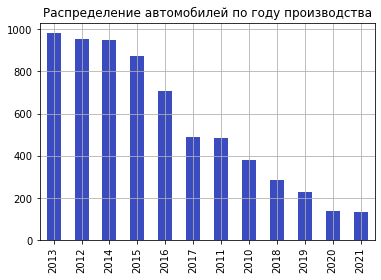

In [80]:
df['productionDate'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей по году производства')

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_21' style="color:blue">21. offers_dict</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_20) | [следующий признак](#f_22)

In [81]:
field = 'offers_dict'
first_look(df,field)

{'"@context"': '"https://schema.org"', '"@type"': '"http://schema.org/Offer"', '"name"': '"Audi A4 IV (B8) Рестайлинг"', '"availability"': '"http://schema.org/InStock"', '"url"': '"https://auto.ru/cars/used/sale/audi/a4/1105531359-1954e109/"', '"price"': '970000', '"priceCurrency"': '"RUB"'}    12
{'"@context"': '"https://schema.org"', '"@type"': '"http://schema.org/Offer"', '"name"': '"Audi A3 III (8V)"', '"availability"': '"http://schema.org/InStock"', '"url"': '"https://auto.ru/cars/used/sale/audi/a3/1106012920-4e3a2efc/"', '"price"': '939000', '"priceCurrency"': '"RUB"'}              12
{'"@context"': '"https://schema.org"', '"@type"': '"http://schema.org/Offer"', '"name"': '"Audi A3 III (8V)"', '"availability"': '"http://schema.org/InStock"', '"url"': '"https://auto.ru/cars/used/sale/audi/a3/1106048968-49e9c3cb/"', '"price"': '950000', '"priceCurrency"': '"RUB"'}              12
{'"@context"': '"https://schema.org"', '"@type"': '"http://schema.org/Offer"', '"name"': '"Audi A5 I (8

В датасете - 1355  разных offers_dict
Пропусков нет


In [82]:
# проглядел - такого признака в тестовой выборке нету -> ставим в список на удаление.
# и в добавок в признаке нет ничего интересного, 
# кроме может в name есть в скобках код поколения модели производителя (но это что-то мелкое).

list_of_columns_to_delete.append(field)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_22' style="color:blue">22. sell_id</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_21) | [следующий признак](#f_23)

In [83]:
field = 'sell_id'
first_look(df,field)

1.106013e+09    12
1.106088e+09    12
1.105531e+09    12
1.105777e+09    12
1.105253e+09    12
                ..
1.105780e+09     1
1.104733e+09     1
1.105841e+09     1
1.105378e+09     1
1.101960e+09     1
Name: sell_id, Length: 1354, dtype: int64

В датасете - 1354  разных sell_id
Пропусков нет


есть повторения, надо будет удалить повторы.

Само поле нам нужно для подтверждения результатов моделирования.

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_23' style="color:blue">23. super_gen</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_22) | [следующий признак](#f_24)

In [84]:
field = 'super_gen'
first_look(df,field)

{"id":"20657612","displacement":2967,"engine_type":"DIESEL","gear_type":"ALL_WHEEL_DRIVE","transmission":"AUTOMATIC","power":249,"power_kvt":183,"human_name":"3.0d AT (249 л.с.) 4WD","acceleration":6.9,"clearance_min":210,"fuel_rate":6.3}                                                    339
{"id":"8351307","displacement":1984,"engine_type":"GASOLINE","gear_type":"ALL_WHEEL_DRIVE","transmission":"AUTOMATIC","power":225,"power_kvt":165,"human_name":"2.0 AT (225 л.с.) 4WD","acceleration":7.1,"clearance_min":200,"fuel_rate":7.9}                                                    335
{"id":"7857337","displacement":1984,"engine_type":"GASOLINE","gear_type":"ALL_WHEEL_DRIVE","transmission":"ROBOT","power":170,"power_kvt":125,"human_name":"2.0 AMT (170 л.с.) 4WD","acceleration":7.8,"clearance_min":170,"fuel_rate":7.7}                                                       259
{"id":"7345621","displacement":1984,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"VARIATOR","

В датасете - 224  разных super_gen
Пропусков нет


технические характеристики автомобилей (без учета комплектации).
Как видим есть повторы, в тестовой выборке они тоже есть.
Можно как вариант закодировать их в буквенное обозначение, чтобы сократить объем используемой памяти.

Надо сделать при объединении наборов данных, чтобы кодировки совпадали.

In [85]:
# создадим список уникальных значений признака super_gen
list_super_gen = pd.Series(df[field].unique()).to_list()

In [86]:
# и проставим код супер-гена в новый признак
df['super_gen_group'] = df['super_gen'].apply(lambda x: list_super_gen.index(x))

# старый можно удалять
list_of_columns_to_delete.append(field)

df['super_gen_group'].value_counts(dropna=False)

121    339
60     335
66     259
39     229
116    194
      ... 
108      1
197      1
222      1
198      1
223      1
Name: super_gen_group, Length: 224, dtype: int64

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_24' style="color:blue">24. vehicleConfiguration</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_23) | [следующий признак](#f_25)

In [87]:
field = 'vehicleConfiguration'
first_look(df,field)

ALLROAD_5_DOORS ROBOT 2.0        962
ALLROAD_5_DOORS AUTOMATIC 3.0    684
SEDAN ROBOT 2.0                  535
ALLROAD_5_DOORS AUTOMATIC 2.0    480
SEDAN ROBOT 1.4                  444
                                ... 
ROADSTER ROBOT 5.2                 3
SEDAN AUTOMATIC 1.4                2
HATCHBACK_3_DOORS ROBOT 1.2        2
LIFTBACK VARIATOR 2.0              2
COUPE ROBOT 1.8                    1
Name: vehicleConfiguration, Length: 69, dtype: int64

В датасете - 69  разных vehicleConfiguration
Пропусков нет


In [88]:
# Почему-то тоже не подтянулся при парсинге, 
# снова воспользуюсь тем, что я сохранил результаты всех запросов и получу недостающие данные

# здесь я их уже подтянул при восстановлении данных productionDate

<AxesSubplot:title={'center':'Распределение автомобилей по их конфигурациям (ТОП-30)'}>

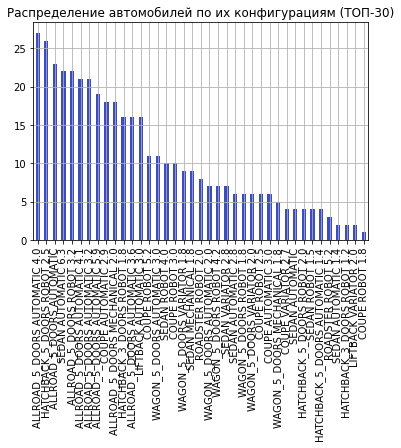

In [91]:
df[field].value_counts()[30:].plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей по их конфигурациям (ТОП-30)')

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_25' style="color:blue">25. vehicleTransmission</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_24) | [следующий признак](#f_26)

In [92]:
field = 'vehicleTransmission'
first_look(df,field)

роботизированная    4143
автоматическая      1740
вариатор             690
механическая          32
Name: vehicleTransmission, dtype: int64

В датасете - 4  разных vehicleTransmission
Пропусков нет


Значения признака совпадают с значениями в тестовой выборке.
Оставляем все как есть.

<AxesSubplot:title={'center':'Распределение автомобилей по коробке передач'}>

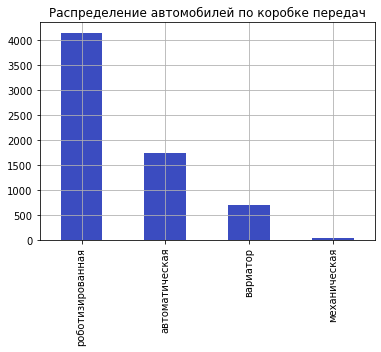

In [93]:
df[field].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей по коробке передач')

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_26' style="color:blue">26. vendor</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_25) | [следующий признак](#f_27)

In [94]:
field = 'vendor'
first_look(df,field)

EUROPEAN    6605
Name: vendor, dtype: int64

В датасете - 1  разных vendor
Пропусков нет


В моей выборке только автомобили Ауди, поэтому тут только одно значение.

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_27' style="color:blue">27. Владельцы</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_26) | [следующий признак](#f_28)

In [95]:
field = 'Владельцы'
first_look(df,field)

3    2433
2    2091
1    2081
Name: Владельцы, dtype: int64

В датасете - 3  разных Владельцы
Пропусков нет


Я уже произвел предобработку признака ранее   
Посмотрим на график

<AxesSubplot:title={'center':'Распределение автомобилей по числу владельцев'}>

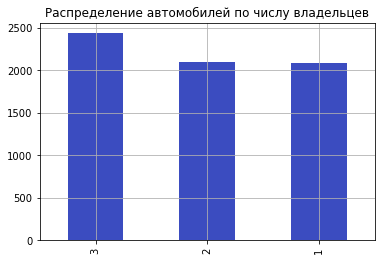

In [96]:
df[field].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей по числу владельцев')

В текущей выборке, распределение практически равномерное.

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_28' style="color:blue">28. Владение</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_27) | [следующий признак](#f_29)

In [97]:
field = 'Владение'
first_look(df,field)

NaN                    4785
9 месяцев                69
1 год                    58
2 месяца                 52
1 год и 12 месяцев       50
                       ... 
2 года и 6 месяцев        3
3 года и 10 месяцев       2
6 лет и 6 месяцев         1
8 лет и 5 месяцев         1
3 года и 11 месяцев       1
Name: Владение, Length: 120, dtype: int64

В датасете - 119  разных Владение
Есть пропуски - посмотрим на них


,0,1,2,3,4,5,6,7,8,9,...,6593,6594,6595,6596,6597,6598,6599,6601,6602,6603
bodyType,лифтбек,лифтбек,лифтбек,лифтбек,лифтбек,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,...,универсал 5 дв.,седан,седан,седан,внедорожник 5 дв.,универсал 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,седан,седан
brand,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,...,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI
car_url,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/q5/1105794...,...,https://auto.ru/cars/used/sale/audi/allroad/11...,https://auto.ru/cars/used/sale/audi/a6/1105418...,https://auto.ru/cars/used/sale/audi/s8/1105782...,https://auto.ru/cars/used/sale/audi/a6/1105710...,https://auto.ru/cars/used/sale/audi/rs_q8/1105...,https://auto.ru/cars/used/sale/audi/rs6/110572...,https://auto.ru/cars/used/sale/audi/q7/1105807...,https://auto.ru/cars/used/sale/audi/q5/1105932...,https://auto.ru/cars/used/sale/audi/a4/1105841...,https://auto.ru/cars/used/sale/audi/a3/1105805...
color,чёрный,чёрный,чёрный,чёрный,чёрный,белый,белый,белый,белый,белый,...,чёрный,серый,чёрный,чёрный,чёрный,серый,белый,серый,белый,белый
complectation_dict,"{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}",...,"{""id"":""22462086"",""name"":""Business 45 TDI tiptr...","{""id"":""21793156"",""name"":""40 TFSI S tronic"",""av...","{""id"":""21877514"",""name"":""TFSI quattro tiptroni...","{""id"":""21594402"",""name"":""Design 45 TFSI quattr...","{""id"":""0""}","{""id"":""22758824"",""name"":""TFSI quattro"",""availa...","{""id"":""21905403"",""name"":""45 TDI quattro tiptro...","{""id"":""0""}","{""id"":""0""}","{""id"":""20838807"",""name"":""Basis"",""available_opt..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
engine_power_group,2,2,2,2,2,1,1,1,1,1,...,1,1,4,1,4,4,1,1,1,1
card_id,1105857554,1105857554,1105857554,1105857554,1105857554,1105794343,1105794343,1105794343,1105794343,1105794343,...,1104931144,1105418143,1105782400,1105710928,1105780694,1105721898,1105807966,1105932008,1105841096,1105805215
productionDate,2010,2010,2010,2010,2010,2011,2011,2011,2011,2011,...,2020,2020,2021,2020,2021,2021,2020,2020,2020,2020
vehicleConfiguration,LIFTBACK ROBOT 3.0,LIFTBACK ROBOT 3.0,LIFTBACK ROBOT 3.0,LIFTBACK ROBOT 3.0,LIFTBACK ROBOT 3.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,...,WAGON_5_DOORS AUTOMATIC 3.0,SEDAN ROBOT 2.0,SEDAN AUTOMATIC 4.0,SEDAN ROBOT 2.0,ALLROAD_5_DOORS AUTOMATIC 4.0,WAGON_5_DOORS AUTOMATIC 4.0,ALLROAD_5_DOORS AUTOMATIC 3.0,ALLROAD_5_DOORS ROBOT 2.0,SEDAN ROBOT 2.0,SEDAN ROBOT 1.4


Поскольку признак представляет из себя текст - переведем его в цифру.
Сделаем новый признак - число месяцев владения.
(старый после этого можно удалить).

In [101]:
# проведем конвертацию поля в числовой признак - месяцев владения
def get_months_owning(row):
    # найдем все числовые значения
    try:
        srch = re.findall(r'\d+', row['Владение']) 
    except:
        srch = []
    
    # переведем всё в месяцы
    if len(srch)>1:
        h = int(srch[0])*12 + int(srch[1])
    elif len(srch)==1:
        h = int(srch[0])
    else:
        h = np.NaN
    
    return h
    
df['months_owning'] = df.apply(lambda row: get_months_owning(row), axis=1)

<AxesSubplot:title={'center':'Распределение автомобилей по числу месяцев владения (ТОП-15)'}>

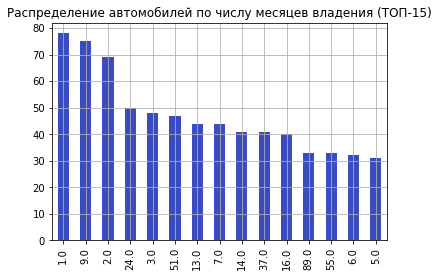

In [115]:
df['months_owning'].value_counts()[:5].plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение автомобилей по числу месяцев владения (ТОП-15)')

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_29' style="color:blue">29. ПТС</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_28) | [следующий признак](#f_30)

In [114]:
field = 'ПТС'
first_look(df,field)

оригинал    5861
дубликат     744
Name: ПТС, dtype: int64

В датасете - 2  разных ПТС
Пропусков нет


По сути это булево значение - надо будет заменить на 0/1 после объединения данных.  

В тестовом наборе есть пропуск - сделаем замены после объединения, по аналогии с числом владельцев (те в привязке к модели автомобиля).

Посмотрим на распределение признака ПТС


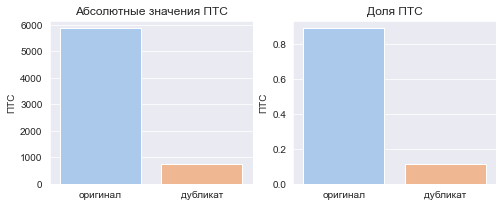

In [182]:
# построим графики
print_field(field)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_30' style="color:blue">30. Привод</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_29) | [следующий признак](#f_31)

Признак содержит информацию о типе привода автомобиля

In [183]:
field = 'Привод'
first_look(df,field)

полный      4594
передний    2011
Name: Привод, dtype: int64

В датасете - 2  разных Привод
Пропусков нет


Посмотрим на распределение признака Привод


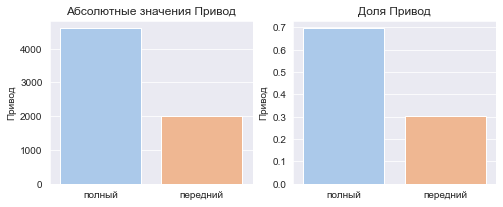

In [184]:
# построим графики
print_field(field)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_31' style="color:blue">31. Руль</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_30) | [следующий признак](#f_32)

Признак содержит значения расположения руля (левое/правое)

In [186]:
field = 'Руль'
first_look(df,field)

левый    6605
Name: Руль, dtype: int64

В датасете - 1  разных Руль
Пропусков нет


<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_32' style="color:blue">32. Состояние</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_31) | [следующий признак](#f_33)

In [187]:
field = 'Состояние'
first_look(df,field)

не требует ремонта    6605
Name: Состояние, dtype: int64

В датасете - 1  разных Состояние
Пропусков нет


In [188]:
# только одно значение во всех строках - такой признак не нужен
list_of_columns_to_delete.append(field)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_33' style="color:blue">33. Таможня</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_32) | [следующий признак](#f_34)

In [189]:
field = 'Таможня'
first_look(df,field)

растаможен    6605
Name: Таможня, dtype: int64

В датасете - 1  разных Таможня
Пропусков нет


In [190]:
# только одно значение во всех строках - такой признак не нужен
list_of_columns_to_delete.append(field)

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_34' style="color:blue">34. car_price</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_33) | [следующий признак](#f_35)

Этот признак нам надо будет предсказать.

<p style="color:green">#############################################################################################</p><br> 

признаки совпадающие с признаками из тестовой выборки закончились - далее мои дополнительные признаки

In [191]:
# посмотрим на список признаков на удаление
print(list_of_columns_to_delete)

['car_url', 'description', 'equipment_dict', 'image', 'model_info', 'parsing_unixtime', 'priceCurrency', 'offers_dict', 'super_gen', 'Состояние', 'Таможня']


<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_35' style="color:blue">35. z_card_data</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_34) | [следующий признак](#f_36)

Признак: дата создания объявления

In [192]:
field = 'z_card_data'
first_look(df,field)

NaN    6605
Name: z_card_data, dtype: int64

В датасете - 0  разных z_card_data
Есть пропуски - посмотрим на них


,0,1,2,3,4,5,6,7,8,9,...,6595,6596,6597,6598,6599,6600,6601,6602,6603,6604
bodyType,лифтбек,лифтбек,лифтбек,лифтбек,лифтбек,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,...,седан,седан,внедорожник 5 дв.,универсал 5 дв.,внедорожник 5 дв.,седан,внедорожник 5 дв.,седан,седан,седан
brand,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,...,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI
car_url,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/q5/1105794...,...,https://auto.ru/cars/used/sale/audi/s8/1105782...,https://auto.ru/cars/used/sale/audi/a6/1105710...,https://auto.ru/cars/used/sale/audi/rs_q8/1105...,https://auto.ru/cars/used/sale/audi/rs6/110572...,https://auto.ru/cars/used/sale/audi/q7/1105807...,https://auto.ru/cars/used/sale/audi/a3/1105890...,https://auto.ru/cars/used/sale/audi/q5/1105932...,https://auto.ru/cars/used/sale/audi/a4/1105841...,https://auto.ru/cars/used/sale/audi/a3/1105805...,https://auto.ru/cars/used/sale/audi/a3/1105870...
color,чёрный,чёрный,чёрный,чёрный,чёрный,белый,белый,белый,белый,белый,...,чёрный,чёрный,чёрный,серый,белый,серый,серый,белый,белый,красный
complectation_dict,"{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}",...,"{""id"":""21877514"",""name"":""TFSI quattro tiptroni...","{""id"":""21594402"",""name"":""Design 45 TFSI quattr...","{""id"":""0""}","{""id"":""22758824"",""name"":""TFSI quattro"",""availa...","{""id"":""21905403"",""name"":""45 TDI quattro tiptro...","{""id"":""20838807"",""name"":""Basis"",""available_opt...","{""id"":""0""}","{""id"":""0""}","{""id"":""20838807"",""name"":""Basis"",""available_opt...","{""id"":""0""}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
card_id,1105857554,1105857554,1105857554,1105857554,1105857554,1105794343,1105794343,1105794343,1105794343,1105794343,...,1105782400,1105710928,1105780694,1105721898,1105807966,1105890122,1105932008,1105841096,1105805215,1105870378
productionDate,2010,2010,2010,2010,2010,2011,2011,2011,2011,2011,...,2021,2020,2021,2021,2020,2020,2020,2020,2020,2020
vehicleConfiguration,LIFTBACK ROBOT 3.0,LIFTBACK ROBOT 3.0,LIFTBACK ROBOT 3.0,LIFTBACK ROBOT 3.0,LIFTBACK ROBOT 3.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,...,SEDAN AUTOMATIC 4.0,SEDAN ROBOT 2.0,ALLROAD_5_DOORS AUTOMATIC 4.0,WAGON_5_DOORS AUTOMATIC 4.0,ALLROAD_5_DOORS AUTOMATIC 3.0,SEDAN ROBOT 1.4,ALLROAD_5_DOORS ROBOT 2.0,SEDAN ROBOT 2.0,SEDAN ROBOT 1.4,SEDAN ROBOT 1.4
super_gen_group,0,0,0,0,0,1,1,1,1,1,...,223,180,202,200,199,155,158,212,155,155


((( промахнулся при парсинге(( данных нету.

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_36' style="color:blue">36. z_card_views_total</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_35) | [следующий признак](#f_37)

Признак: суммарное число просмотров объявления

In [194]:
field = 'z_card_views_total'
first_look(df,field)

NaN        51
142.0      40
276.0      28
363.0      26
306.0      25
           ..
11485.0     1
452.0       1
919.0       1
11483.0     1
54.0        1
Name: z_card_views_total, Length: 1671, dtype: int64

В датасете - 1670  разных z_card_views_total
Есть пропуски - посмотрим на них


,550,862,863,865,889,925,937,949,973,985,...,5051,5058,5059,5065,5066,5079,5086,5093,5100,5270
bodyType,внедорожник 5 дв.,седан,седан,внедорожник 5 дв.,седан,седан,внедорожник 5 дв.,седан,седан,внедорожник 5 дв.,...,универсал 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,седан,седан,седан,универсал 5 дв.,седан
brand,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,...,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI
car_url,https://auto.ru/cars/used/sale/audi/q5/1105969...,https://auto.ru/cars/used/sale/audi/a4/1105951...,https://auto.ru/cars/used/sale/audi/a8/1092297...,https://auto.ru/cars/used/sale/audi/q5/1105878...,https://auto.ru/cars/used/sale/audi/a6/1105737...,https://auto.ru/cars/used/sale/audi/a4/1105593...,https://auto.ru/cars/used/sale/audi/q5/1105363...,https://auto.ru/cars/used/sale/audi/a6/1105995...,https://auto.ru/cars/used/sale/audi/a6/1105703...,https://auto.ru/cars/used/sale/audi/q5/1105648...,...,https://auto.ru/cars/used/sale/audi/a4/1106053...,https://auto.ru/cars/used/sale/audi/q5/1105792...,https://auto.ru/cars/used/sale/audi/q5/1105792...,https://auto.ru/cars/used/sale/audi/q3/1105830...,https://auto.ru/cars/used/sale/audi/q3/1105830...,https://auto.ru/cars/used/sale/audi/a4/1105167...,https://auto.ru/cars/used/sale/audi/a4/1106053...,https://auto.ru/cars/used/sale/audi/a4/1106045...,https://auto.ru/cars/used/sale/audi/a6/1106036...,https://auto.ru/cars/used/sale/audi/a6/1105968...
color,серый,синий,чёрный,коричневый,чёрный,чёрный,белый,чёрный,белый,белый,...,чёрный,синий,синий,белый,белый,белый,белый,синий,бежевый,чёрный
complectation_dict,"{""id"":""0""}","{""id"":""2324184"",""name"":""Стандарт"",""available_o...","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""6937691"",""name"":""Базовая"",""available_op...","{""id"":""0""}",...,"{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""21112648"",""name"":""Design"",""available_op...","{""id"":""21133211"",""name"":""Sport"",""available_opt...","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
card_id,1105969656,1105951672,1092297550,1105878870,1105737343,1105593341,1105363261,1105995943,1105703326,1105648558,...,1106053501,1105792115,1105792115,1105830017,1105830017,1105167275,1106053164,1106045612,1106036160,1105968144
productionDate,2011,2011,2011,2013,2012,2013,2013,2012,2012,2012,...,2017,2016,2016,2016,2016,2016,2016,2017,2017,2017
vehicleConfiguration,ALLROAD_5_DOORS ROBOT 2.0,SEDAN VARIATOR 1.8,SEDAN AUTOMATIC 4.2,ALLROAD_5_DOORS AUTOMATIC 2.0,SEDAN ROBOT 3.0,SEDAN VARIATOR 1.8,ALLROAD_5_DOORS AUTOMATIC 2.0,SEDAN VARIATOR 2.0,SEDAN ROBOT 2.8,ALLROAD_5_DOORS ROBOT 2.0,...,WAGON_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS AUTOMATIC 2.0,ALLROAD_5_DOORS AUTOMATIC 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,SEDAN ROBOT 1.4,SEDAN ROBOT 2.0,SEDAN ROBOT 2.0,WAGON_5_DOORS ROBOT 2.0,SEDAN ROBOT 1.8
super_gen_group,1,9,29,60,61,62,60,39,8,1,...,161,151,151,116,116,127,120,153,154,113


<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_37' style="color:blue">37. z_card_views_today</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_36) | [следующий признак](#f_38)

Признак: число просмотров объявления сегодня

In [195]:
field = 'z_card_views_today'
first_look(df,field)

NaN      922
1.0      793
2.0      603
3.0      519
4.0      416
        ... 
122.0      1
141.0      1
140.0      1
336.0      1
109.0      1
Name: z_card_views_today, Length: 178, dtype: int64

В датасете - 177  разных z_card_views_today
Есть пропуски - посмотрим на них


,550,861,862,863,864,865,866,867,868,877,...,6293,6306,6315,6477,6478,6479,6519,6520,6521,6603
bodyType,внедорожник 5 дв.,седан,седан,седан,седан,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,...,седан,внедорожник 5 дв.,седан,седан,седан,седан,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,седан
brand,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,...,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI
car_url,https://auto.ru/cars/used/sale/audi/q5/1105969...,https://auto.ru/cars/used/sale/audi/a4/1105647...,https://auto.ru/cars/used/sale/audi/a4/1105951...,https://auto.ru/cars/used/sale/audi/a8/1092297...,https://auto.ru/cars/used/sale/audi/a6/1105645...,https://auto.ru/cars/used/sale/audi/q5/1105878...,https://auto.ru/cars/used/sale/audi/q5/1105878...,https://auto.ru/cars/used/sale/audi/q5/1105878...,https://auto.ru/cars/used/sale/audi/q5/1105878...,https://auto.ru/cars/used/sale/audi/q7/1105648...,...,https://auto.ru/cars/used/sale/audi/a4/1104828...,https://auto.ru/cars/used/sale/audi/q7/1105752...,https://auto.ru/cars/used/sale/audi/a4/1105961...,https://auto.ru/cars/used/sale/audi/a4/1106016...,https://auto.ru/cars/used/sale/audi/a4/1106016...,https://auto.ru/cars/used/sale/audi/a4/1106016...,https://auto.ru/cars/used/sale/audi/e_tron/110...,https://auto.ru/cars/used/sale/audi/e_tron/110...,https://auto.ru/cars/used/sale/audi/e_tron/110...,https://auto.ru/cars/used/sale/audi/a3/1105805...
color,серый,чёрный,синий,чёрный,чёрный,коричневый,коричневый,коричневый,коричневый,чёрный,...,белый,белый,белый,чёрный,чёрный,чёрный,синий,синий,синий,белый
complectation_dict,"{""id"":""0""}","{""id"":""0""}","{""id"":""2324184"",""name"":""Стандарт"",""available_o...","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}",...,"{""id"":""0""}","{""id"":""21639291"",""name"":""Business 45 TDI quatt...","{""id"":""21532142"",""name"":""Advance"",""available_o...","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""20838807"",""name"":""Basis"",""available_opt..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
card_id,1105969656,1105647745,1105951672,1092297550,1105645288,1105878870,1105878870,1105878870,1105878870,1105648982,...,1104828964,1105752927,1105961424,1106016278,1106016278,1106016278,1105674513,1105674513,1105674513,1105805215
productionDate,2011,2011,2011,2011,2011,2013,2013,2013,2013,2013,...,2019,2018,2018,2020,2020,2020,2020,2020,2020,2020
vehicleConfiguration,ALLROAD_5_DOORS ROBOT 2.0,SEDAN VARIATOR 2.0,SEDAN VARIATOR 1.8,SEDAN AUTOMATIC 4.2,SEDAN ROBOT 2.8,ALLROAD_5_DOORS AUTOMATIC 2.0,ALLROAD_5_DOORS AUTOMATIC 2.0,ALLROAD_5_DOORS AUTOMATIC 2.0,ALLROAD_5_DOORS AUTOMATIC 2.0,ALLROAD_5_DOORS AUTOMATIC 3.0,...,SEDAN ROBOT 1.4,ALLROAD_5_DOORS AUTOMATIC 3.0,SEDAN ROBOT 1.4,SEDAN ROBOT 2.0,SEDAN ROBOT 2.0,SEDAN ROBOT 2.0,ALLROAD_5_DOORS AUTOMATIC,ALLROAD_5_DOORS AUTOMATIC,ALLROAD_5_DOORS AUTOMATIC,SEDAN ROBOT 1.4
super_gen_group,1,59,9,29,8,60,60,60,60,35,...,127,121,127,208,208,208,188,188,188,155


<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_38' style="color:blue">38. z_model_name_full</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_37) | [следующий признак](#f_39)

Признак: полное наименование модели

In [196]:
field = 'z_model_name_full'
first_look(df,field)

['Q5', 'I', '(8R)', 'Рестайлинг']               507
['A6', 'IV', '(C7)']                            424
['A3', 'III', '(8V)']                           413
['A4', 'V', '(B9)']                             398
['Q7', 'II', '(4M)']                            372
                                               ... 
['TT', 'II', '(8J)']                              2
['A1', 'I', '(8X)', 'Рестайлинг']                 2
['S8', 'IV', '(D5)']                              1
['A6', 'allroad', '45', 'TDI', 'IV', '(C8)']      1
['A6', '55', 'TFSI', 'V', '(C8)']                 1
Name: z_model_name_full, Length: 98, dtype: int64

В датасете - 98  разных z_model_name_full
Пропусков нет


<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_39' style="color:blue">39. z_model_name_short</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_38) | [следующий признак](#f_40)

Признак: короткое наименование модели

In [197]:
field = 'z_model_name_short'
first_look(df,field)

Q5        987
A6        983
A4        938
Q7        687
A3        635
Q3        588
A5        498
A7        355
A8        261
RS        233
A1        154
TT         90
Q8         53
e-tron     23
S5         21
SQ7        19
S8         18
TTS        16
R8         14
S3         13
S6         10
SQ5         6
SQ8         3
Name: z_model_name_short, dtype: int64

В датасете - 23  разных z_model_name_short
Пропусков нет


<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_40' style="color:blue">40. z_engine_volume</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_39) | [следующий признак](#f_41)

Признак: объем двигателя

In [198]:
field = 'z_engine_volume'
first_look(df,field)

2.0        2837
3.0        1479
1.4         866
1.8         584
2.8         217
4.0         180
1.2          92
4.2          82
2.5          78
3.2          43
6.3          22
4.1          21
5.9          19
2.9          18
408л.с.      18
3.6          16
5.2          14
1.5           6
313л.с.       5
646л.с.       4
2.7           4
Name: z_engine_volume, dtype: int64

В датасете - 21  разных z_engine_volume
Пропусков нет


Как видно по некоторым объявлениям вместо объема спарсилась мощность

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_41' style="color:blue">41. z_engine_power</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_40) | [следующий признак](#f_42)

Признак: мощность двигателя

In [199]:
field = 'z_engine_power'
first_look(df,field)

249       851
170       593
180       515
225       488
211       442
190       384
122       375
245       371
150       359
310       238
230       184
333       178
125       167
204       148
300       135
177       106
340        93
160        91
105        71
450        70
220        70
560        66
120        59
290        50
272        49
435        47
500        41
239        35
372        30
238        27
270        22
271        21
110        21
250        19
422        18
300кВт     18
520        17
280        16
367        15
354        14
525        14
600        13
143        10
420        10
605         8
218         6
252         6
400         6
286         5
230кВт      5
475кВт      4
200         3
571         1
Name: z_engine_power, dtype: int64

В датасете - 53  разных z_engine_power
Пропусков нет


А здесь у некоторых объявлений вместо мощности в лс мощность в кВт

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_42' style="color:blue">42. z_engine_type</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_41) | [следующий признак](#f_43)

Признак: тип двигателя

In [200]:
field = 'z_engine_type'
first_look(df,field)

бензин                                5357
дизель                                1205
электро                                 27
бензин, газобаллонное оборудование       9
гибрид                                   7
Name: z_engine_type, dtype: int64

В датасете - 5  разных z_engine_type
Пропусков нет


Как видим есть бензиновый двигатель с дополнительным газовым балоном. Надо будет оставить только бензин.

ПС. По факту можно сделать доппризнак есть второй источник топлива для двигателя (я его не сделал, мысль пришла уже при оформлении ноутбука).

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_43' style="color:blue">43. z_complectation</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_42) | [следующий признак](#f_44)

Признак: комплектация автомобиля

In [201]:
field = 'z_complectation'
first_look(df,field)

NaN                          706
Базовая                      475
Sport                        214
30 опций                     167
1 опция                      152
                            ... 
Design 55 TFSI                 2
78 опций                       2
Design 45 TDI                  2
TFSI quattro tiptronic         1
Business 45 TDI tiptronic      1
Name: z_complectation, Length: 141, dtype: int64

В датасете - 140  разных z_complectation
Есть пропуски - посмотрим на них


,25,26,27,28,29,95,96,97,98,99,...,6513,6514,6515,6528,6529,6530,6563,6564,6592,6601
bodyType,седан,седан,седан,седан,седан,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,...,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,седан,седан,седан,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.
brand,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,...,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI
car_url,https://auto.ru/cars/used/sale/audi/a4/1106053...,https://auto.ru/cars/used/sale/audi/a4/1106053...,https://auto.ru/cars/used/sale/audi/a4/1106053...,https://auto.ru/cars/used/sale/audi/a4/1106053...,https://auto.ru/cars/used/sale/audi/a4/1106053...,https://auto.ru/cars/used/sale/audi/q5/1105881...,https://auto.ru/cars/used/sale/audi/q5/1105881...,https://auto.ru/cars/used/sale/audi/q5/1105881...,https://auto.ru/cars/used/sale/audi/q5/1105881...,https://auto.ru/cars/used/sale/audi/q5/1105881...,...,https://auto.ru/cars/used/sale/audi/sq8/110566...,https://auto.ru/cars/used/sale/audi/sq8/110566...,https://auto.ru/cars/used/sale/audi/sq8/110566...,https://auto.ru/cars/used/sale/audi/a6/1105517...,https://auto.ru/cars/used/sale/audi/a6/1105517...,https://auto.ru/cars/used/sale/audi/a6/1105517...,https://auto.ru/cars/used/sale/audi/q7/1106057...,https://auto.ru/cars/used/sale/audi/q7/1106057...,https://auto.ru/cars/used/sale/audi/e_tron/110...,https://auto.ru/cars/used/sale/audi/q5/1105932...
color,серый,серый,серый,серый,серый,коричневый,коричневый,коричневый,коричневый,коричневый,...,серый,серый,серый,чёрный,чёрный,чёрный,коричневый,коричневый,голубой,серый
complectation_dict,"{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}",...,"{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
card_id,1106053873,1106053873,1106053873,1106053873,1106053873,1105881631,1105881631,1105881631,1105881631,1105881631,...,1105669736,1105669736,1105669736,1105517405,1105517405,1105517405,1106057414,1106057414,1105710927,1105932008
productionDate,2011,2011,2011,2011,2011,2010,2010,2010,2010,2010,...,2021,2021,2021,2021,2021,2021,2020,2020,2020,2020
vehicleConfiguration,SEDAN ROBOT 2.0,SEDAN ROBOT 2.0,SEDAN ROBOT 2.0,SEDAN ROBOT 2.0,SEDAN ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,...,ALLROAD_5_DOORS AUTOMATIC 4.0,ALLROAD_5_DOORS AUTOMATIC 4.0,ALLROAD_5_DOORS AUTOMATIC 4.0,SEDAN ROBOT 2.0,SEDAN ROBOT 2.0,SEDAN ROBOT 2.0,ALLROAD_5_DOORS AUTOMATIC 3.0,ALLROAD_5_DOORS AUTOMATIC 3.0,ALLROAD_5_DOORS AUTOMATIC,ALLROAD_5_DOORS ROBOT 2.0
super_gen_group,5,5,5,5,5,1,1,1,1,1,...,216,216,216,180,180,180,199,199,206,158


Очень много пропусков((

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_44' style="color:blue">44. z_transport_tax</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_43) | [следующий признак](#f_45)

Признак: налог на автомобиль

In [202]:
field = 'z_transport_tax'
first_look(df,field)

18675.0     694
7650.0      509
9000.0      479
14625.0     456
13715.0     391
           ... 
4380.0        1
5700.0        1
14940.0       1
8673.0        1
256950.0      1
Name: z_transport_tax, Length: 92, dtype: int64

В датасете - 92  разных z_transport_tax
Пропусков нет


<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_45' style="color:blue">45. z_card_city</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_44) | [следующий признак](#f_46)

Признак: город продажи автомобиля

In [203]:
field = 'z_card_city'
first_look(df,field)

Москва      5869
Балашиха      90
Тула          54
Химки         46
Рязань        41
            ... 
Бородино       1
Соболиха       1
Дарьино        1
Ховрино        1
Дедовск        1
Name: z_card_city, Length: 89, dtype: int64

В датасете - 89  разных z_card_city
Пропусков нет


<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_46' style="color:blue">46. z_mileage_dict</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_45) | [следующий признак](#f_47)

Признак: пробег автомобиля

In [204]:
field = 'z_mileage_dict'
first_look(df,field)

140000    53
130000    46
170000    45
125000    44
155000    43
          ..
103068     1
132800     1
34250      1
204000     1
5000       1
Name: z_mileage_dict, Length: 914, dtype: int64

В датасете - 914  разных z_mileage_dict
Пропусков нет


<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_47' style="color:blue">47. z_catalogParams_dict</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_46) | [следующий признак](#f_48)

Признак: параметры каталога

In [205]:
field = 'z_catalogParams_dict'
first_look(df,field)

{"category":"cars","mark":"AUDI","model":"Q5","super_gen":"8351293","configuration_id":"8351305","complectation_id":"8351305__8351307"}                     335
{"category":"cars","mark":"AUDI","model":"Q3","super_gen":"7341708","configuration_id":"7341709","complectation_id":"7341709_20071857_7857337"}             259
{"category":"cars","mark":"AUDI","model":"A6","super_gen":"6937659","configuration_id":"6937662","complectation_id":"6937662_6937691_7345621"}              229
{"category":"cars","mark":"AUDI","model":"Q7","super_gen":"20368749","configuration_id":"20368784","complectation_id":"20368784_20943589_20657612"}         199
{"category":"cars","mark":"AUDI","model":"A3","super_gen":"7979586","configuration_id":"9288088","complectation_id":"9288088__9288097"}                     168
                                                                                                                                                           ... 
{"category":"cars","mark":"AUDI","model"

В датасете - 297  разных z_catalogParams_dict
Пропусков нет


в признаке есть уникальные configuration_id и complectation_id, в теории можно было бы использовать для моделирования.
(если бы они были в тестовой выборке) - тогда можно было бы спокойно убирать признаки оборудования и опций.

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_48' style="color:blue">48. z_vehicle_info_dict</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_47) | [следующий признак](#f_49)

Признак: словарь справочник информации по автомобилю

In [207]:
field = 'z_vehicle_info_dict'
first_look(df,field)

{"id":"8351305","body_type":"ALLROAD_5_DOORS","doors_count":5,"auto_class":"J","human_name":"Внедорожник 5 дв.","trunk_volume_min":540,"trunk_volume_max":1560,"body_type_group":"ALLROAD_5_DOORS","main_photo":{"sizes":{"orig":"//avatars.mds.yandex.net/get-verba/787013/2a000001609d410044d50ba5ebaf88ec6af3/orig","wizardv3mr":"//avatars.mds.yandex.net/get-verba/787013/2a000001609d410044d50ba5ebaf88ec6af3/wizardv3mr","cattouch":"//avatars.mds.yandex.net/get-verba/787013/2a000001609d410044d50ba5ebaf88ec6af3/cattouch"}                                   507
{"id":"6937662","body_type":"SEDAN","doors_count":4,"auto_class":"E","human_name":"Седан","trunk_volume_min":530,"trunk_volume_max":995,"body_type_group":"SEDAN","main_photo":{"sizes":{"orig":"//avatars.mds.yandex.net/get-verba/787013/2a000001609cf3e6cbca06fc7e146aed639b/orig","wizardv3mr":"//avatars.mds.yandex.net/get-verba/787013/2a000001609cf3e6cbca06fc7e146aed639b/wizardv3mr","cattouch":"//avatars.mds.yandex.net/get-verba/787013/2a00000

В датасете - 96  разных z_vehicle_info_dict
Пропусков нет


Отсюда можно взять класс автомобиля "auto_class":"D", для дополнительной группировки данных.

In [209]:
df[field][0]

'{"id":"6457125","body_type":"LIFTBACK","doors_count":5,"auto_class":"E","human_name":"Лифтбек","trunk_volume_min":535,"trunk_volume_max":1360,"body_type_group":"LIFTBACK","main_photo":{"sizes":{"orig":"//avatars.mds.yandex.net/get-verba/937147/2a000001609d350c74d4c04e6b0c9b1633ac/orig","wizardv3mr":"//avatars.mds.yandex.net/get-verba/937147/2a000001609d350c74d4c04e6b0c9b1633ac/wizardv3mr","cattouch":"//avatars.mds.yandex.net/get-verba/937147/2a000001609d350c74d4c04e6b0c9b1633ac/cattouch"}'

In [212]:
def get_auto_class(x):
    try:
        h = json.loads(x+str('}}'))['auto_class']
    except:
        h = np.NaN
    
    return h

# это можно будет сделать если получится спарсить объявления по тестовой базе
# посмотрел по ответам сайта - там нет этой информации(((((
# ПС. можно было бы сделать через словарь из train набора, но чего-то упустил - не сделал((

df['auto_class'] = df[field].apply(lambda x: get_auto_class(x))

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_49' style="color:blue">49. z_tech_param_dict</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_48) | [следующий признак](#f_50)

Признак: словарь технических параметров автомобиля

In [213]:
field = 'z_tech_param_dict'
first_look(df,field)

{"id":"20657612","displacement":2967,"engine_type":"DIESEL","gear_type":"ALL_WHEEL_DRIVE","transmission":"AUTOMATIC","power":249,"power_kvt":183,"human_name":"3.0d AT (249 л.с.) 4WD","acceleration":6.9,"clearance_min":210,"fuel_rate":6.3}                                                    339
{"id":"8351307","displacement":1984,"engine_type":"GASOLINE","gear_type":"ALL_WHEEL_DRIVE","transmission":"AUTOMATIC","power":225,"power_kvt":165,"human_name":"2.0 AT (225 л.с.) 4WD","acceleration":7.1,"clearance_min":200,"fuel_rate":7.9}                                                    335
{"id":"7857337","displacement":1984,"engine_type":"GASOLINE","gear_type":"ALL_WHEEL_DRIVE","transmission":"ROBOT","power":170,"power_kvt":125,"human_name":"2.0 AMT (170 л.с.) 4WD","acceleration":7.8,"clearance_min":170,"fuel_rate":7.7}                                                       259
{"id":"7345621","displacement":1984,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"VARIATOR","

В датасете - 224  разных z_tech_param_dict
Пропусков нет


для проданных авто - информации нету.
признак на удаление((

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_50' style="color:blue">50. z_sold_check</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_49) | [следующий признак](#f_51)

Признак: признак продажи автомобиля

In [217]:
field = 'z_sold_check'
first_look(df,field)

NaN    6605
Name: z_sold_check, dtype: int64

В датасете - 0  разных z_sold_check
Есть пропуски - посмотрим на них


,0,1,2,3,4,5,6,7,8,9,...,6595,6596,6597,6598,6599,6600,6601,6602,6603,6604
bodyType,лифтбек,лифтбек,лифтбек,лифтбек,лифтбек,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,внедорожник 5 дв.,...,седан,седан,внедорожник 5 дв.,универсал 5 дв.,внедорожник 5 дв.,седан,внедорожник 5 дв.,седан,седан,седан
brand,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,...,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI,AUDI
car_url,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/a7/1105857...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/q5/1105794...,https://auto.ru/cars/used/sale/audi/q5/1105794...,...,https://auto.ru/cars/used/sale/audi/s8/1105782...,https://auto.ru/cars/used/sale/audi/a6/1105710...,https://auto.ru/cars/used/sale/audi/rs_q8/1105...,https://auto.ru/cars/used/sale/audi/rs6/110572...,https://auto.ru/cars/used/sale/audi/q7/1105807...,https://auto.ru/cars/used/sale/audi/a3/1105890...,https://auto.ru/cars/used/sale/audi/q5/1105932...,https://auto.ru/cars/used/sale/audi/a4/1105841...,https://auto.ru/cars/used/sale/audi/a3/1105805...,https://auto.ru/cars/used/sale/audi/a3/1105870...
color,чёрный,чёрный,чёрный,чёрный,чёрный,белый,белый,белый,белый,белый,...,чёрный,чёрный,чёрный,серый,белый,серый,серый,белый,белый,красный
complectation_dict,"{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}","{""id"":""0""}",...,"{""id"":""21877514"",""name"":""TFSI quattro tiptroni...","{""id"":""21594402"",""name"":""Design 45 TFSI quattr...","{""id"":""0""}","{""id"":""22758824"",""name"":""TFSI quattro"",""availa...","{""id"":""21905403"",""name"":""45 TDI quattro tiptro...","{""id"":""20838807"",""name"":""Basis"",""available_opt...","{""id"":""0""}","{""id"":""0""}","{""id"":""20838807"",""name"":""Basis"",""available_opt...","{""id"":""0""}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
productionDate,2010,2010,2010,2010,2010,2011,2011,2011,2011,2011,...,2021,2020,2021,2021,2020,2020,2020,2020,2020,2020
vehicleConfiguration,LIFTBACK ROBOT 3.0,LIFTBACK ROBOT 3.0,LIFTBACK ROBOT 3.0,LIFTBACK ROBOT 3.0,LIFTBACK ROBOT 3.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS ROBOT 2.0,...,SEDAN AUTOMATIC 4.0,SEDAN ROBOT 2.0,ALLROAD_5_DOORS AUTOMATIC 4.0,WAGON_5_DOORS AUTOMATIC 4.0,ALLROAD_5_DOORS AUTOMATIC 3.0,SEDAN ROBOT 1.4,ALLROAD_5_DOORS ROBOT 2.0,SEDAN ROBOT 2.0,SEDAN ROBOT 1.4,SEDAN ROBOT 1.4
super_gen_group,0,0,0,0,0,1,1,1,1,1,...,223,180,202,200,199,155,158,212,155,155
months_owning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,14.0


в данном признаке пропуски это нормально - означает, что автомобиль не продан

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_51' style="color:blue">51. z_price_info_dict</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_50) | [следующий признак](#f_52)

Признак: словарь цены автомобиля

In [214]:
field = 'z_price_info_dict'
first_look(df,field)

{"price":1500000,"currency":"RUR","EUR":17657,"RUR":1500000,"USD":19845,"with_nds":false}        126
{"price":1350000,"currency":"RUR","EUR":15891,"RUR":1350000,"USD":17860,"with_nds":false}        100
{"price":1300000,"currency":"RUR","EUR":15303,"RUR":1300000,"USD":17199,"with_nds":false}         82
{"price":1600000,"currency":"RUR","EUR":18834,"RUR":1600000,"USD":21168,"with_nds":false}         74
{"price":1200000,"currency":"RUR","EUR":14126,"RUR":1200000,"USD":15876,"with_nds":false}         73
                                                                                                ... 
{"price":16685747,"currency":"RUR","EUR":196412,"RUR":16685747,"USD":220748,"with_nds":false}      1
{"price":15449000,"currency":"RUR","EUR":181854,"RUR":15449000,"USD":204386,"with_nds":false}      1
{"price":2880000,"currency":"RUR","EUR":33901,"RUR":2880000,"USD":38102,"with_nds":false}          1
{"price":1930000,"currency":"RUR","EUR":22719,"RUR":1930000,"USD":25533,"with_nds":false}  

В датасете - 699  разных z_price_info_dict
Пропусков нет


пока нет идеи как можно использовать((  
лишнее - удаляю.

<p style="color:green">#############################################################################################</p><br>
<font size="4">  
<a id='f_52' style="color:blue">52. z_price_history_dict</a></font> 

[назад к списку признаков](#featches) | [предыдущий признак](#f_51) |

Признак: словарь история изменения цены автомобиля

In [216]:
field = 'z_price_history_dict'
first_look(df,field)

{"EUR":26474,"RUR":2249000,"USD":29754,"create_timestamp":1637605383000}    15
{"EUR":45308,"RUR":3849000,"USD":50921,"create_timestamp":1637864531000}    12
{"EUR":15126,"RUR":1285000,"USD":17000,"create_timestamp":1637753848000}    12
{"EUR":11183,"RUR":950000,"USD":12568,"create_timestamp":1637573327000}     12
{"EUR":17539,"RUR":1490000,"USD":19712,"create_timestamp":1637740297000}    12
                                                                            ..
{"EUR":28251,"RUR":2400000,"USD":31751,"create_timestamp":1637243087000}     1
{"EUR":40022,"RUR":3400000,"USD":44981,"create_timestamp":1636695389000}     1
{"EUR":8240,"RUR":700000,"USD":9261,"create_timestamp":1630330600000}        1
{"EUR":14714,"RUR":1250000,"USD":16537,"create_timestamp":1637000848000}     1
{"EUR":9417,"RUR":800000,"USD":10584,"create_timestamp":1634462217000}       1
Name: z_price_history_dict, Length: 1352, dtype: int64

В датасете - 1352  разных z_price_history_dict
Пропусков нет


пока нет идеи как можно использовать((  
лишнее - удаляю.

<p style="color:green">#############################################################################################</p><br>
<font size="5">  
<a id='p_2' style="color:blue">2. Выводы</a></font> 

[назад к оглавлению](#chapters) | [предыдущая часть](#p_1) |

Итак:
1. Данных много, и есть мои ошибки при парсинге (необходимо их исправить)
2. Проработал признаки и придумал немного новых дополнительных признаков.
3. По сути этот ноутбук - это проверка корректности парсинга и начало работы над генерацией новых признаков